# Stroke Prediction Dataset

According to the World Health Organization (WHO) stroke is the 2nd leading cause of death globally, responsible for approximately 11% of total deaths. \
The goal of the project is to predict whether a patient is likely to have a stroke based on various health and demographic features, like gender, age, various diseases, and smoking status.\
Each row in the data provides relevant information about each patient.

The stroke prediction dataset was created by McKinsey & Company. The data originates from medical records associated with 5110 individuals residing in Bangladesh.

In [54]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import math
from rich.console import Console
from phik import phik_matrix
from scipy.stats import (
    ttest_ind,
    pointbiserialr,
    chi2_contingency,
    spearmanr,
    fisher_exact,
    shapiro,
    skew,
    levene,
    ks_2samp,
    mannwhitneyu,
)
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from scipy import stats
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
import random
from sklearn.neighbors import KNeighborsClassifier

import warnings

warnings.filterwarnings("ignore")
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["axes.facecolor"] = "white"
plt.rcParams["axes.edgecolor"] = "lightgrey"
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False
console = Console(soft_wrap=True)

### Load and Explore the Data

In [55]:
df = pd.read_csv("healthcare-dataset-stroke-data.csv")
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [56]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,5110.0,36517.829354,21161.721625,67.00,17741.250,36932.000,54682.00,72940.00
age,5110.0,43.226614,22.612647,0.08,25.000,45.000,61.00,82.00
hypertension,5110.0,0.097456,0.296607,0.00,0.000,0.000,0.00,1.00
heart_disease,5110.0,0.054012,0.226063,0.00,0.000,0.000,0.00,1.00
avg_glucose_level,5110.0,106.147677,45.283560,55.12,77.245,91.885,114.09,271.74
bmi,4909.0,28.893237,7.854067,10.30,23.500,28.100,33.10,97.60
stroke,5110.0,0.048728,0.215320,0.00,0.000,0.000,0.00,1.00


In [57]:
df.describe(include="object").T

,count,unique,top,freq
gender,5110,3,Female,2994
ever_married,5110,2,Yes,3353
work_type,5110,5,Private,2925
Residence_type,5110,2,Urban,2596
smoking_status,5110,4,never smoked,1892


In [58]:
likely_cat_col = [
    "gender",
    "ever_married",
    "work_type",
    "Residence_type",
    "smoking_status",
]

for col in likely_cat_col:
    print(
        (df[col].value_counts(normalize=True) * 100)
        .round(2)
        .to_string()
    )

gender
Female    58.59
Male      41.39
Other      0.02
ever_married
Yes    65.62
No     34.38
work_type
Private          57.24
Self-employed    16.03
children         13.44
Govt_job         12.86
Never_worked      0.43
Residence_type
Urban    50.8
Rural    49.2
smoking_status
never smoked       37.03
Unknown            30.22
formerly smoked    17.32
smokes             15.44


In [59]:
# In gender column, there is only one "Other" value. We can drop this row.
df = df[df["gender"] != "Other"]
df.reset_index(drop=True, inplace=True)

In [60]:
print(f"Number of negative value entries")
for num_var in df.select_dtypes(include=np.number).columns:
    non_neg_check = (
        df[num_var].dropna().apply(lambda x: 0 if x >= 0 else 1)
    )
    print(f"{num_var}: {non_neg_check.sum()}")

Number of negative value entries
id: 0
age: 0
hypertension: 0
heart_disease: 0
avg_glucose_level: 0
bmi: 0
stroke: 0


In [61]:
df.drop("id", axis=1, inplace=True)
df.rename({"Residence_type": "residence_type"}, axis=1, inplace=True)

In [62]:
if df.isnull().sum().sum() > 0:
    print("There are missing values in the dataset:")
    print(df.isnull().sum())
else:
    print("There are no missing values in the dataset")
print()
if df.duplicated().sum() > 0:
    print(
        f"There are {df.duplicated().sum()} duplicated values in the dataset"
    )
    print("Removing duplicated data...")
    df.drop_duplicates(inplace=True)
    df.reset_index(drop=True, inplace=True)
    print("Done")
else:
    print("There are no duplicated values in the dataset")

There are missing values in the dataset:
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

There are no duplicated values in the dataset


### Exploratory Data Analysis

#### Handling Missing Values

There are missing values in the `bmi` feature, accounting for approximately 4% of the total data. Before deciding on a handling strategy (and choosing an imputation method (such as KNNImputer, \
SimpleImputer, or a predictive model like Random Forest or KNN)), we will examine whether other features can help predict these missing values and determine the most appropriate approach. \
To do so, we will first analyze the dataset excluding the missing values.

In [63]:
data = df.dropna()
data.reset_index(drop=True, inplace=True)
data.isnull().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

#### Check the Distribution of the Target Variable

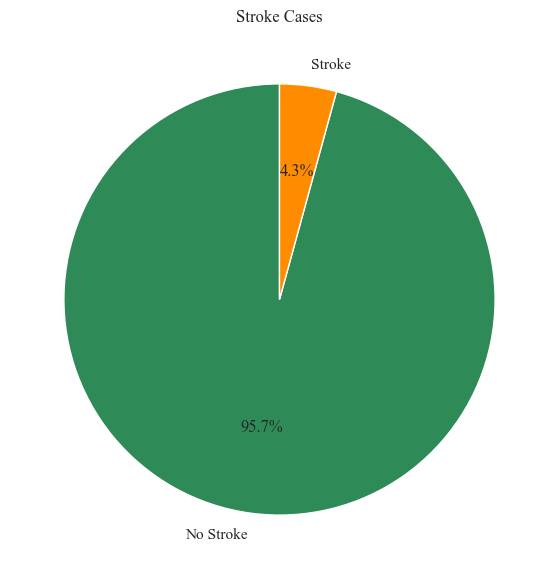

In [64]:
data.stroke.value_counts().plot.pie(
    autopct="%1.1f%%",
    colors=["seagreen", "darkorange"],
    startangle=90,
    labels=["No Stroke", "Stroke"],
    figsize=(7, 7),
)
plt.title("Stroke Cases")
plt.ylabel("")
plt.show()

In [65]:
print(
    f"Total number of patients in the dataset with stroke: {data.stroke.sum()}"
)
print(
    f"Total number of patients in the dataset without stroke: {data.stroke.value_counts()[0]}"
)
print(
    f"Probability of a patient within the whole dataset having strokes: {round(data.stroke.mean(),2)}"
)

Total number of patients in the dataset with stroke: 209
Total number of patients in the dataset without stroke: 4699
Probability of a patient within the whole dataset having strokes: 0.04


Only a small percentage of users experienced a stroke. Both the exploratory data analysis (EDA) and predictive model construction will account for this class imbalance.

#### Check the Age Distribution among Children


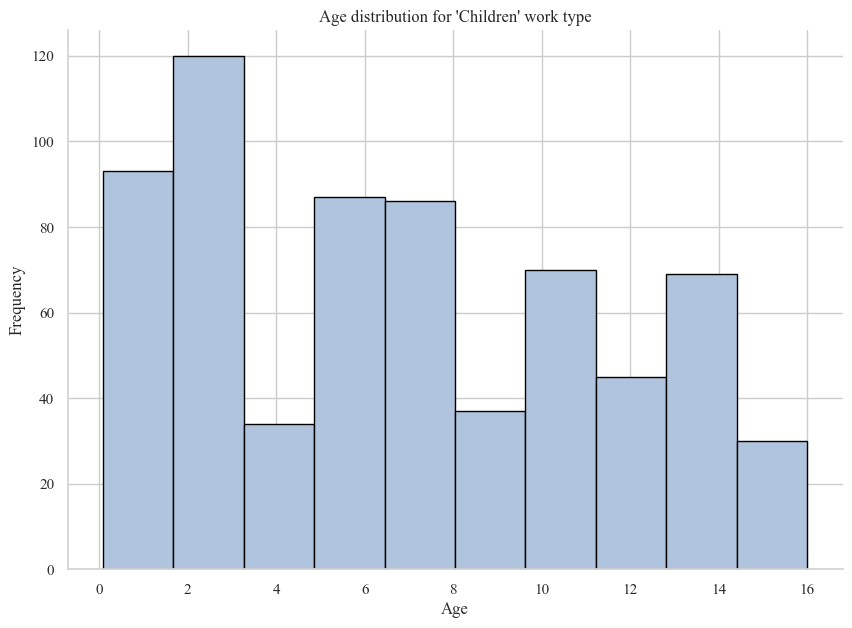

In [66]:
data[data.work_type == "children"].age.plot(
    kind="hist",
    color="lightsteelblue",
    edgecolor="black",
    figsize=(10, 7),
)
plt.xlabel("Age")
plt.title("Age distribution for 'Children' work type")
plt.show()

Below the age of 18, the work type is children. We can see that the age distribution for children is between 0 and 16 years old.

#### Check for Outliers

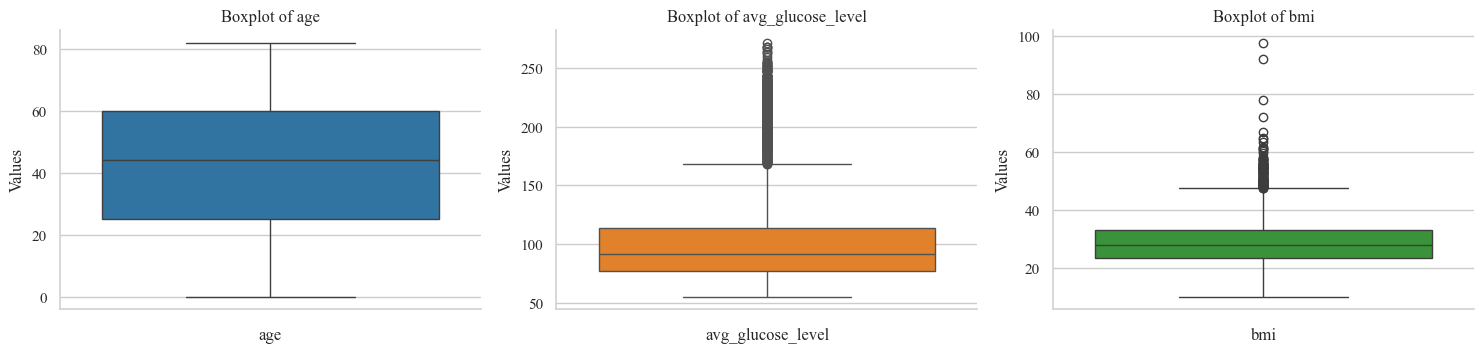

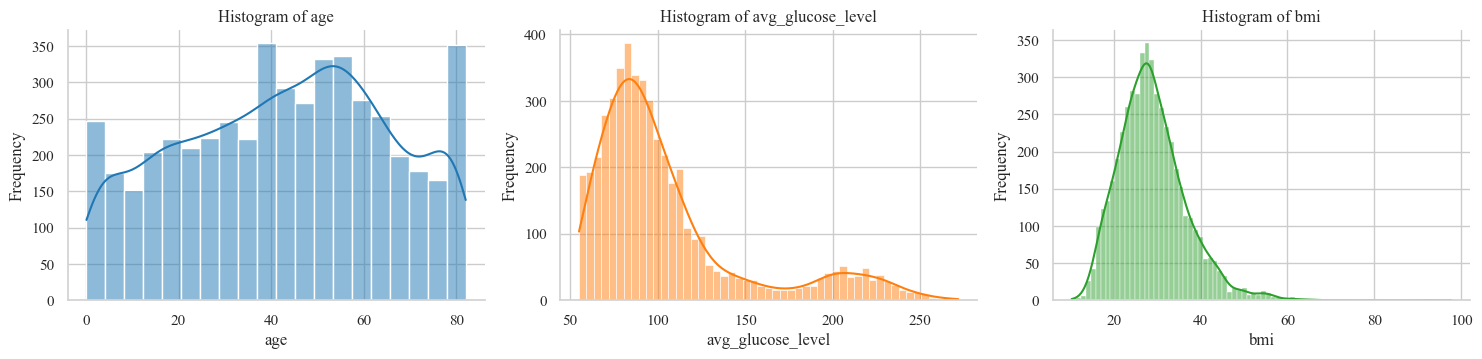

In [67]:
num_variables = data.drop(
    ["hypertension", "heart_disease", "stroke"], axis=1
).select_dtypes(include=["int64", "float64"])

tot = math.ceil(len(num_variables) / 3)
row = math.ceil(len(num_variables) / tot)

colors = sns.color_palette("tab10", len(num_variables))

plt.figure(figsize=(15, 10))
for i, var in enumerate(num_variables):
    plt.subplot(row, 3, i + 1)
    sns.boxplot(data[var], color=colors[i])
    plt.title(f"Boxplot of {var}")
    plt.xlabel(var)
    plt.ylabel("Values")
plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 10))
for i, var in enumerate(num_variables):
    plt.subplot(row, 3, i + 1)
    sns.histplot(data[var], kde=True, color=colors[i])
    plt.title(f"Histogram of {var}")
    plt.xlabel(var)
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

For `Age`, there are no outliers. The distribution is almost normal. For `average glucose level` and `bmi`, \
there are several outliers, and the distribution is right-skewed. Nevertheless, the outliers represent possible real-life values, \
and we will retain them, acknowledging their potential impact on subsequent analyses. 

#### Explore relationships between Numerical Features and Stroke

To explore potential relationships between the numerical variables and the target, we will perform a statistical test. \
The choice of test is critical, as imbalanced data can increase the likelihood of violating the assumptions of parametric tests, \
leading to unreliable results. Therefore, we will begin by using the Shapiro-Wilk test to assess normality and Levene's test 
to assess the equality of variances.


In [68]:
for var in num_variables:
    stat, p = shapiro(num_variables[var])
    stat_levene, p_levene = stats.levene(
        data[data.stroke == 0][var], data[data.stroke == 1][var]
    )
    console.print(f"Variable: [bold]{var}[/bold]")
    print(f"Shapiro={stat:.3f}, p={p:.3f}")
    print(f"Levene={stat_levene:.3f}, p={p_levene:.3f}")
    alpha = 0.05
    if p > alpha:
        print("Sample looks Gaussian (fail to reject H0)")
    else:
        print("Sample does not look Gaussian (reject H0)")
    if p_levene > alpha:
        print("Equal variances (fail to reject H0)")
    else:
        print("Unequal variances (reject H0)")
    print()

Variable: age

Shapiro=0.968, p=0.000
Levene=106.992, p=0.000
Sample does not look Gaussian (reject H0)
Unequal variances (reject H0)



Variable: avg_glucose_level

Shapiro=0.806, p=0.000
Levene=94.889, p=0.000
Sample does not look Gaussian (reject H0)
Unequal variances (reject H0)



Variable: bmi

Shapiro=0.954, p=0.000
Levene=10.424, p=0.001
Sample does not look Gaussian (reject H0)
Unequal variances (reject H0)



In all three cases, the **p-value** from the **Shapiro-Wilk** test is **lower** than the significance threshold, \
indicating that **we reject the null hypothesis of normality**. \
Similarly, the **p-values from Levene's** test are **lower** than 0.05 for all features, leading us to **reject the \
null hypothesis of equal variances**. Therefore, we will use the **Mann-Whitney U test**, which does not assume normality or equal variances. \
While it does assume independence of observations, it is less sensitive to distributional assumptions \
than the t-test, making it **more suitable for our imbalanced data**. To quantify the effect size in the \
Mann-Whitney U test, we compute **Cliff’s Delta**. To estimate its confidence interval (CI), we use **bootstrapping**. 

#### Formulate Hypothesis for Numerical Features

- For **BMI**:

    - **H₀**: There is no difference in BMI between those who have stroke and those who don’t.
    - **H₁**: People who have stroke have a higher BMI value.
<br/><br/>
- For **Age**:

    - **H₀**: Age does not affect the likelihood of having stroke.
    - **H₁**: Older individuals are more likely to have a stroke.
<br/><br/>
- For **Avg_glucose_levels**:

    - **H₀**: The value of average glucose level does not influence the likelihood of having stroke.
    - **H₁**: People with high average glucose level are more likely to have a stroke.


In [69]:
def mann_whitney(data, feature, target):
    stroke_group = data[data[target] == 1][feature]
    no_stroke_group = data[data[target] == 0][feature]

    u_stat, p_value = mannwhitneyu(
        stroke_group, no_stroke_group, alternative="two-sided"
    )
    cliffs_d = (2 * u_stat) / (
        len(stroke_group) * len(no_stroke_group)
    ) - 1

    return u_stat, p_value, cliffs_d


def bootstrap_mann_whitney_ci(
    data, feature, target, n_iterations=1000, ci=95
):
    stroke_group = data[data[target] == 1][feature].values
    no_stroke_group = data[data[target] == 0][feature].values
    cliffs_deltas = []

    for _ in range(n_iterations):

        stroke_sample = np.random.choice(
            stroke_group, size=len(stroke_group), replace=True
        )
        no_stroke_sample = np.random.choice(
            no_stroke_group, size=len(no_stroke_group), replace=True
        )

        u_stat, _ = mannwhitneyu(
            stroke_sample, no_stroke_sample, alternative="two-sided"
        )
        cliffs_d = (2 * u_stat) / (
            len(stroke_sample) * len(no_stroke_sample)
        ) - 1
        cliffs_deltas.append(cliffs_d)

    lower = (100 - ci) / 2
    upper = 100 - lower
    ci_low, ci_high = np.percentile(cliffs_deltas, [lower, upper])

    return ci_low, ci_high


np.random.seed(42)
num_variables = ["age", "avg_glucose_level", "bmi"]

for feature in num_variables:
    u_stat, p, cliffs_d = mann_whitney(data, feature, "stroke")
    ci_low, ci_high = bootstrap_mann_whitney_ci(
        data, feature, "stroke", n_iterations=1000, ci=95
    )

    console.print(f"Variable: [bold]{feature}[/bold]")
    print(f"U Statistic: {u_stat:.3f}, p-value: {p:.4f}")
    print(
        f"Cliff's Delta: {cliffs_d:.3f} (95% CI: [{ci_low:.3f}, {ci_high:.3f}])"
    )
    if p < 0.05:
        print(
            "Reject null hypothesis: There is a significant difference between groups"
        )
    else:
        print(
            "Fail to reject null hypothesis: There is no significant difference between groups"
        )
    print()

Variable: age

U Statistic: 821071.500, p-value: 0.0000
Cliff's Delta: 0.672 (95% CI: [0.631, 0.714])
Reject null hypothesis: There is a significant difference between groups



Variable: avg_glucose_level

U Statistic: 614199.000, p-value: 0.0000
Cliff's Delta: 0.251 (95% CI: [0.154, 0.340])
Reject null hypothesis: There is a significant difference between groups



Variable: bmi

U Statistic: 568828.000, p-value: 0.0001
Cliff's Delta: 0.158 (95% CI: [0.089, 0.220])
Reject null hypothesis: There is a significant difference between groups



Overall, the results indicate significant differences between stroke and non-stroke groups in `Age`, `Average Glucose Level`, and `BMI`:


1. **Age** is the strongest predictor:

    - Very strong effect: Delta > 0.474 
    - Stroke patients are much older (mean age 67.7 vs. 41.8).
    - Narrow CI confirms robustness.

2. **Avg Glucose Level** is also important:

    - Delta ~0.25, which is translated in medium effect.
    - Higher glucose levels are linked to stroke, but the effect is smaller than age.
    - CI doesn’t cross zero, but includes "small" to "medium" effects.

3. **BMI** shows a small but statistically significant effect:

    - Delta ~0.16 (small but non-trivial).
    -  p < 0.001 is highly significant.
    - Wider CI suggests variability—BMI’s role may depend on other factors (e.g., age, hypertension).

`Age` is the strongest predictor of stroke (large effect size, Δ = 0.67), followed by `average glucose level` (moderate effect, Δ = 0.25) and `BMI` (small effect, Δ = 0.16). 
All three variables are statistically significant (p < 0.001), but **age** has the **most consistent and clinically meaningful** association.

#### Result Visualization

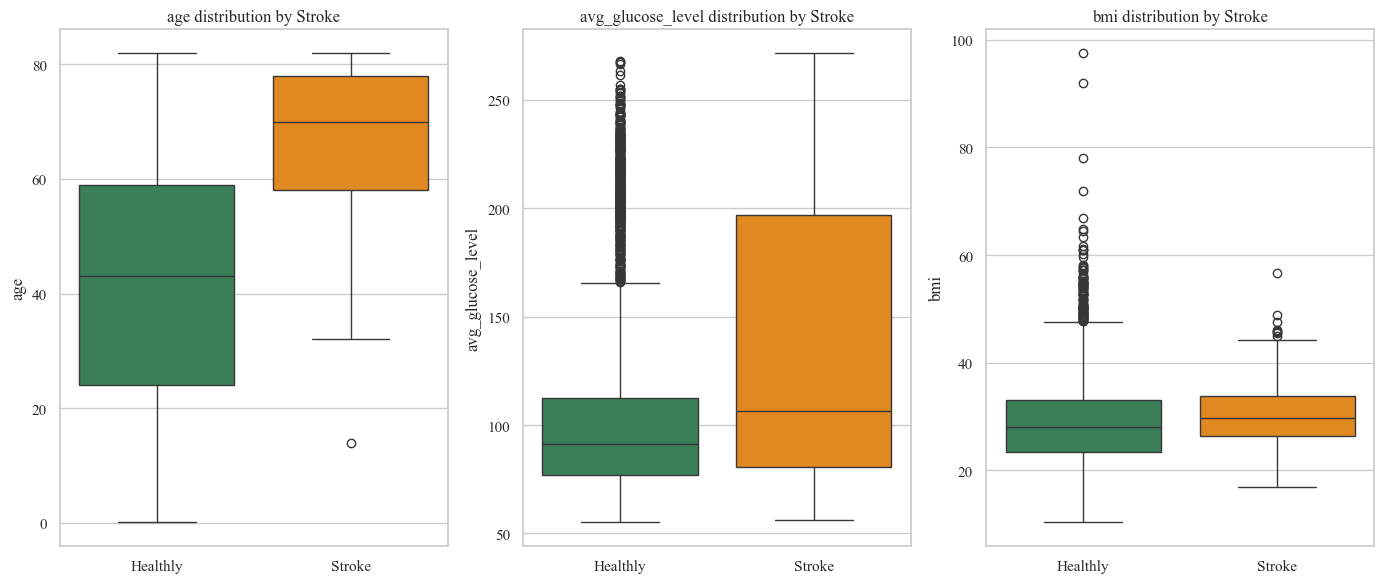

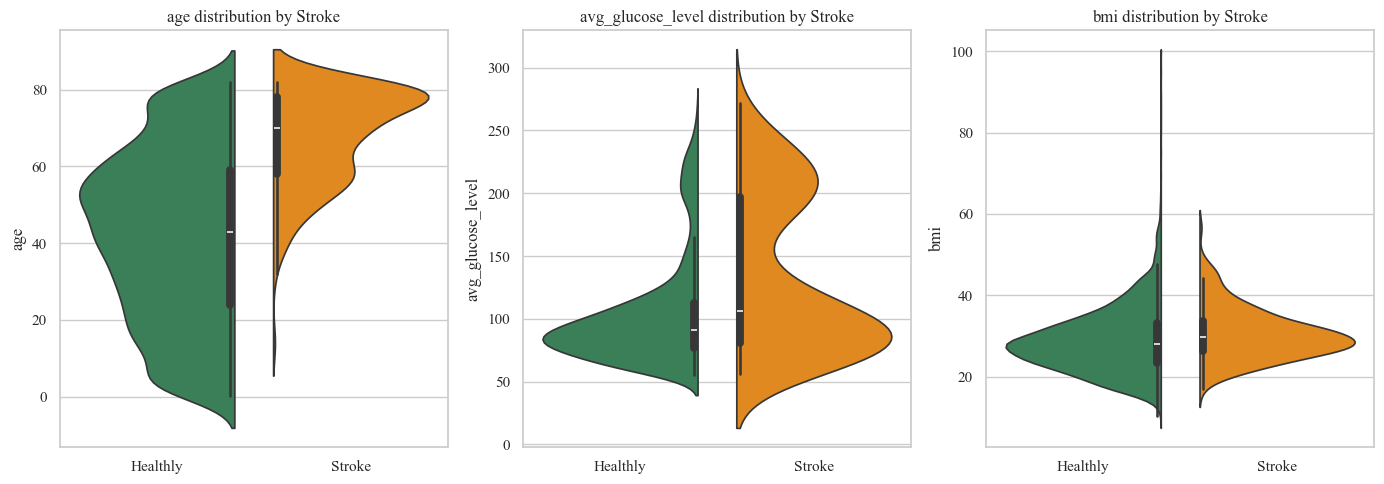

In [70]:
sns.set(style="whitegrid", font="Times New Roman")

fig, axes = plt.subplots(1, 3, figsize=(14, 6))
for i, var in enumerate(["age", "avg_glucose_level", "bmi"]):
    sns.boxplot(
        x="stroke",
        y=var,
        data=data,
        ax=axes[i],
        palette=["seagreen", "darkorange"],
    )
    axes[i].set_title(f"{var} distribution by Stroke")
    axes[i].set_xlabel("")
    axes[i].set_xticklabels(["Healthly", "Stroke"])
    axes[i].set_ylabel(var)

plt.tight_layout()

fig, axes = plt.subplots(1, 3, figsize=(14, 5))
for i, var in enumerate(["age", "avg_glucose_level", "bmi"]):
    sns.violinplot(
        x="stroke",
        y=var,
        data=data,
        split=True,
        palette=["seagreen", "darkorange"],
        ax=axes[i],
        scale="width",
    )
    axes[i].set_title(f"{var} distribution by Stroke")
    axes[i].set_xlabel("")
    axes[i].set_xticklabels(["Healthly", "Stroke"])
    axes[i].set_ylabel(var)

plt.tight_layout()
plt.show()

#### Stroke Incidence across Categorical Risk Factors: BMI, Age, and Glucose Levels

To improve interpretability, we'll convert numerical variables (`BMI`, `age`, and `average glucose level`) into ordinal categories based on established clinical guidelines:
- [Adult BMI Categories](https://www.cdc.gov/bmi/adult-calculator/bmi-categories.html)
- [Stages of Life: Health for Every Age](https://integrishealth.org/resources/on-your-health/2015/october/stages-of-life-health-for-every-age)
- [The Global Health Observatory](https://www.who.int/data/gho/indicator-metadata-registry/imr-details/2380#:~:text=The%20expected%20values%20for%20normal,and%20monitoring%20glycemia%20are%20recommended.)


In [71]:
data["bmi_cat"] = pd.cut(
    data["bmi"],
    bins=[
        0,
        18.5,
        25,
        30,
        100,
    ],  # Classified according to CDC adult BMI standards
    labels=["Underweight", "Ideal", "Overweight", "Obesity"],
    right=False,
)

data["age_cat"] = pd.cut(
    data["age"],
    bins=[
        0,
        13,
        20,
        40,
        60,
        100,
    ],  # Based on life-stage health classifications
    labels=[
        "Children",
        "Teens",
        "Adults",
        "Mid Adults",
        "Senior Adults",
    ],
    right=False,
)

data["glucose_cat"] = pd.cut(
    data["avg_glucose_level"],
    bins=[
        0,
        70,
        100,
        125,
        np.inf,
    ],  # Categorized per WHO glycemic thresholds
    labels=["Low", "Normal", "Prediabetes", "High"],
    right=False,
)

data.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke,bmi_cat,age_cat,glucose_cat
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1,Obesity,Senior Adults,High
1,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1,Obesity,Senior Adults,Prediabetes
2,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1,Obesity,Mid Adults,High
3,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1,Ideal,Senior Adults,High
4,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1,Overweight,Senior Adults,High


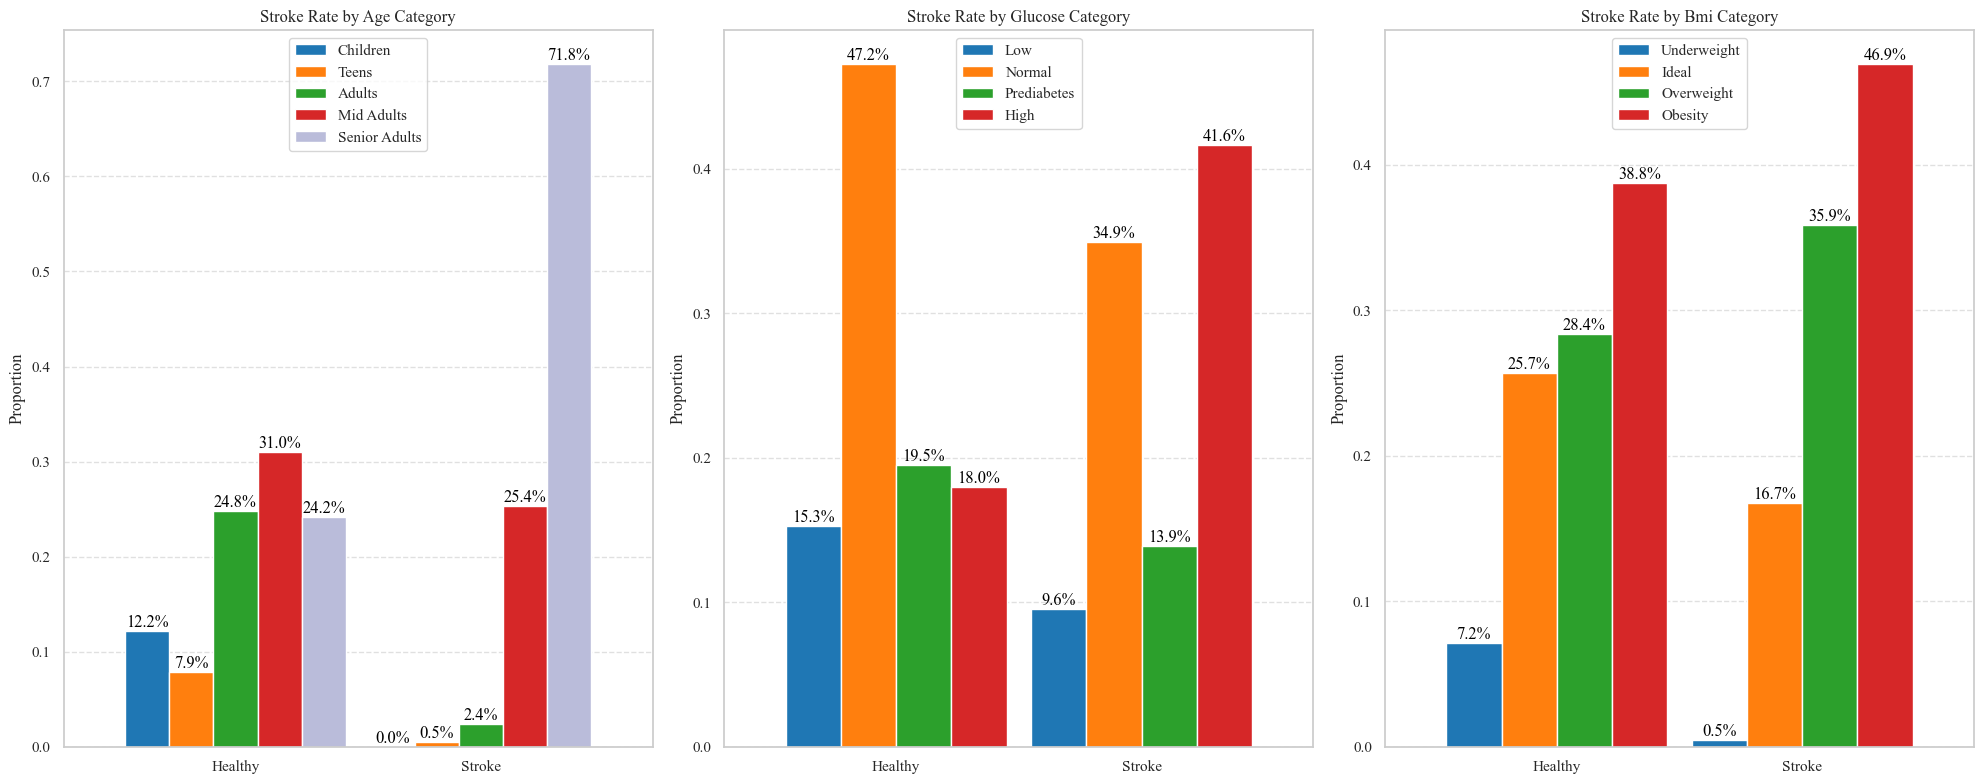

In [72]:
features = ["age_cat", "glucose_cat", "bmi_cat"]
proportions = []

fig, axes = plt.subplots(1, 3, figsize=(20, 8))
for i, var in enumerate(features):
    data.groupby("stroke")[var].value_counts(
        normalize=True
    ).unstack().plot(
        kind="bar",
        ax=axes[i],
        color=[
            "#1f77b4",
            "#ff7f0e",
            "#2ca02c",
            "#d62728",
            "#BABCDA",
        ],
        width=0.9,
    )
    axes[i].set_title(
        f"Stroke Rate by {var.capitalize().split('_')[0]} Category"
    )
    axes[i].set_xlabel("")
    axes[i].set_ylabel("Proportion")
    axes[i].set_xticklabels(["Healthy", "Stroke"], rotation=0)
    axes[i].grid(False)
    axes[i].legend(loc="upper center")
    axes[i].grid(axis="y", linestyle="--", alpha=0.6)
    proportions.append(
        data.groupby("stroke")[var].value_counts().unstack()
    )
    for tick in axes[i].get_xticklabels():
        tick.set_rotation(0)

for ax in axes.flatten():
    if ax.has_data():
        for i, p in enumerate(ax.patches):
            height = p.get_height()
            ax.annotate(
                f"{height*100:.1f}%",
                (p.get_x() + p.get_width() / 2, p.get_height()),
                ha="center",
                va="bottom",
                color="black",
                size=12,
            )

plt.tight_layout()
plt.savefig("stroke_rate_by_numerical.png", dpi=300)
plt.show()

#### Explore relationships between Categorical Features and Stroke

To investigate potential relationships between categorical variables and the target variable, we will conduct statistical tests. The choice of test depends on the expected cell counts in the contingency table:

- **Chi-Square Test:** Used when all expected cell counts are ≥5, ensuring the approximation to the chi-square distribution is valid.

- **Fisher’s Exact Test:** Applied when any expected cell count is <5 and the variable has only two categories (2x2 table), as Fisher’s test provides an exact p-value without relying on approximations.

- **Monte Carlo Simulation for Chi-Square:** Used when any expected cell count is <5 and the variable has more than two categories. In this case, we estimate the p-value using random permutations to account for small sample sizes and ensure the validity of the test.

#### Formulate Hypothesis for Categorical Features 

- For **Gender**:

    - **H₀**: There is no association between gender and stroke occurrence.
    - **H₁**: Stroke occurrence differs significantly between genders.
<br/><br/>
- For **Ever Married**:

    - **H₀**: Marital status is independent of stroke occurrence.
    - **H₁**: There is an association between marital status and stroke occurrence.
<br/><br/>
- For **Work Type**:

    - **H₀**: Stroke occurrence is equally distributed across work types.
    - **H₁**: Stroke occurrence differs significantly by work type.
<br/><br/>
- For **Residence Type**:

    - **H₀**: Residence type (urban/rural) is not associated with stroke occurrence.
    - **H₁**: Urban residents have different stroke incidence than rural residents.
<br/><br/>
- For **Smoking Status**:

    - **H₀**: Smoking status is independent of stroke occurrence.
    - **H₁**: There is an association between smoking status and stroke occurrence.
<br/><br/>
- For **Hypertension**:

    - **H₀**: Hypertension status is not associated with stroke occurrence.
    - **H₁**: Individuals with hypertension have higher stroke incidence.
<br/><br/>
- For **Heart Disease**:

    - **H₀**: Heart disease status is not associated with stroke occurrence.
    - **H₁**: Individuals with heart disease have higher stroke incidence.

In [73]:
categorical_cols = [
    "gender",
    "ever_married",
    "work_type",
    "residence_type",
    "smoking_status",
    "hypertension",
    "heart_disease",
]


def bootstrap_ci(
    data,
    variable,
    target="stroke",
    n_bootstrap=1000,
    ci=95,
    reference_category=None,
):
    """
    Compute bootstrap CI for the odds ratio of a categorical variable vs. stroke.

    Args:
        data (pd.DataFrame): The dataset.
        variable (str): The categorical variable.
        target (str): The binary outcome variable (default: 'stroke').
        n_bootstrap (int): Number of bootstrap resamples.
        ci (int): Confidence interval level (default: 95).
        reference_category (str, optional): The category to use as reference. If None, the mode is used.

    Returns:
        list[dict]: A list of dictionaries containing odds ratios and confidence intervals.
    """
    if reference_category is None:
        reference_category = data[variable].mode()[0]

    categories = [
        cat
        for cat in data[variable].unique()
        if cat != reference_category
    ]
    results = []

    for category in categories:
        odds_ratios = []

        for _ in range(n_bootstrap):
            positive = data[data[target] == 1].sample(frac=1, replace=True)
            negative = data[data[target] == 0].sample(frac=1, replace=True)
            sample = pd.concat([positive, negative])

            a = sample[
                (sample[variable] == reference_category)
                & (sample[target] == 1)
            ].shape[0]
            b = sample[
                (sample[variable] == reference_category)
                & (sample[target] == 0)
            ].shape[0]
            c = sample[
                (sample[variable] == category)
                & (sample[target] == 1)
            ].shape[0]
            d = sample[
                (sample[variable] == category)
                & (sample[target] == 0)
            ].shape[0]

            epsilon = 0.5 if min(a, b, c, d) == 0 else 1e-6
            or_val = ((a + epsilon) * (d + epsilon)) / (
                (b + epsilon) * (c + epsilon)
            )
            odds_ratios.append(or_val)

        lower = np.percentile(odds_ratios, (100 - ci) / 2)
        upper = np.percentile(odds_ratios, 100 - (100 - ci) / 2)

        results.append(
            {
                "category": category,
                "odds_ratio": np.mean(odds_ratios),
                "ci_lower": lower,
                "ci_upper": upper,
            }
        )

    return results


for val in categorical_cols:
    contingency_table = pd.crosstab(data[val], data["stroke"])
    chi2_stat, p_value, dof, expected = chi2_contingency(
    contingency_table)
    if val == "hypertension" or val == "heart_disease":
        reference_category = 1
    else:
        reference_category = data[val].mode()[0]

    # Case 1: Fisher’s Exact Test for 2x2 tables with small expected counts
    if data[val].nunique() == 2 and np.any(expected < 5):
        table_2x2 = pd.crosstab(
            data[val] == reference_category, data["stroke"]
        )
        odds_ratio, fisher_p = fisher_exact(table_2x2)

        ci_results = bootstrap_ci(
            data, val, reference_category=reference_category
        )
        ci_low, ci_high = (
            ci_results[0]["ci_lower"],
            ci_results[0]["ci_upper"],
        )

        console.print(f"Variable: [bold]{val}[/bold]")
        console.print(
            f"Fisher's Exact Test: OR={odds_ratio:.3f}, p-value={fisher_p:.4f}, Odds Ratio CI: [{ci_low:.3f}, {ci_high:.3f}]"
        )

        if fisher_p < 0.05:
            console.print(
                "[green]Reject H0: Significant association with stroke[/green]"
            )
        else:
            console.print(
                "[yellow]Fail to reject H0: No significant association[/yellow]"
            )

    # Case 2: Monte Carlo Correction for contingency tables larger than 2x2 with small expected counts
    elif data[val].nunique() > 2 and np.any(expected < 5):
        chi2_stat, p_value, dof, expected = chi2_contingency(
            contingency_table, correction=False
        )
        simulated_p_values = [
            chi2_contingency(
                pd.crosstab(
                    data[val], np.random.permutation(data["stroke"])
                ),
                correction=False,
            )[1]
            for _ in range(10000)
        ]
        monte_p = np.mean(np.array(simulated_p_values) <= p_value)

        ci_results = bootstrap_ci(
            data, val, reference_category=reference_category
        )

        console.print(f"Variable: [bold]{val}[/bold]")
        console.print(
            f"Chi-Square Test with Monte Carlo Correction: Chi2 = {chi2_stat:.3f}, Monte Carlo p-value = {monte_p:.4f}, reference category: {reference_category}"
        )
        for res in ci_results:
            console.print(
                f"  OR ({res['category']}): {res['odds_ratio']:.3f}, CI: [{res['ci_lower']:.3f}, {res['ci_upper']:.3f}]"
            )

        if monte_p < 0.05:
            console.print(
                "[green]Reject H0: Significant association with stroke[/green]"
            )
        else:
            console.print(
                "[yellow]Fail to reject H0: No significant association[/yellow]"
            )

    # Case 3: Standard Chi-Square Test (if expected counts are large enough)
    else:
        ci_results = bootstrap_ci(
            data, val, reference_category=reference_category
        )
        console.print(f"Variable: [bold]{val}[/bold]")
        if data[val].nunique() > 2 and np.any(expected > 5):
            console.print(
                f"Chi-Square Statistic = {chi2_stat:.3f}, p-value = {p_value:.4f}, df = {dof}, reference category: {reference_category}"
            )
            for res in ci_results:
                console.print(
                    f"  OR ({res['category']}): {res['odds_ratio']:.3f}, CI: [{res['ci_lower']:.3f}, {res['ci_upper']:.3f}]"
                )
        elif data[val].nunique() == 2 and np.any(expected > 5):
            res = ci_results[0]
            console.print(
                f"Chi-Square Statistic = {chi2_stat:.3f}, p-value = {p_value:.4f}, df = {dof}, reference category: {reference_category}, CI: [{res['ci_lower']:.3f}, {res['ci_upper']:.3f}]"
            )

        if p_value < 0.05:
            console.print(
                "[green]Reject H0: Significant association with stroke[/green]"
            )
        else:
            console.print(
                "[yellow]Fail to reject H0: No significant association[/yellow]"
            )

Variable: gender

Chi-Square Statistic = 0.170, p-value = 0.6805, df = 1, reference category: Female, CI: [0.707, 1.249]

Fail to reject H0: No significant association

Variable: ever_married

Chi-Square Statistic = 53.076, p-value = 0.0000, df = 1, reference category: Yes, CI: [3.079, 7.281]

Reject H0: Significant association with stroke

Variable: work_type

Chi-Square Test with Monte Carlo Correction: Chi2 = 41.951, Monte Carlo p-value = 0.0000, reference category: Private

OR (Self-employed): 0.662, CI: [0.482, 0.923]

OR (Govt_job): 1.063, CI: [0.687, 1.641]

OR (children): 39.235, CI: [9.630, 71.040]

OR (Never_worked): 2.140, CI: [1.329, 3.047]

Reject H0: Significant association with stroke

Variable: residence_type

Chi-Square Statistic = 0.122, p-value = 0.7272, df = 1, reference category: Urban, CI: [0.803, 1.421]

Fail to reject H0: No significant association

Variable: smoking_status

Chi-Square Statistic = 35.006, p-value = 0.0000, df = 3, reference category: never smoked

OR (formerly smoked): 0.665, CI: [0.472, 0.928]

OR (smokes): 0.876, CI: [0.582, 1.292]

OR (Unknown): 2.480, CI: [1.582, 3.831]

Reject H0: Significant association with stroke

Variable: hypertension

Chi-Square Statistic = 97.239, p-value = 0.0000, df = 1, reference category: 1, CI: [3.246, 5.963]

Reject H0: Significant association with stroke

Variable: heart_disease

Chi-Square Statistic = 90.250, p-value = 0.0000, df = 1, reference category: 1, CI: [3.531, 7.411]

Reject H0: Significant association with stroke

1. **Gender** is likely not a significant predictor of stroke in this dataset.

    - The Chi-Square statistic (0.170) is relatively small, further supporting the lack of a strong association.
    - The p-value (0.6805) is much greater than 0.05, indicating that we fail to reject the null hypothesis. There's insufficient evidence to conclude a statistically significant association between gender and stroke.
    - The 95% confidence interval for the odds ratio is [0.701, 1.246]. Because this interval includes 1, it suggests that the odds of stroke are not significantly different between genders.
<br/><br/>

2. **Ever Married** is significantly associated with stroke risk in this dataset.

    - The Chi-Square statistic (53.076) is large, confirming the strong association.
    - The p-value (0.0000) is far below 0.05, leading to the rejection of the null hypothesis. There's a strong and statistically significant association between ever being married and the occurrence of stroke.
    - The 95% confidence interval for the odds ratio is [3.058, 7.399]. Since this interval is entirely above 1, it strongly suggests that being married is associated with significantly higher odds of having a stroke.
<br/><br/>

3. **Work Type** is significantly associated with stroke risk.

    - The reference category is "Private".
    - The Chi-Square statistic (41.951) is large, supporting the significant association.
    - The Monte Carlo p-value (0.0000) is much smaller than 0.05, so we reject the null hypothesis. There's strong evidence of an association between work type and stroke.
    - Odds Ratio:
        - Self-employed individuals have significantly lower odds of stroke compared to individuals working in the "Private" sector. The confidence interval does not include 1, indicating statistical significance.
        - Individuals with "Govt_job" have slightly higher (but practically the same) odds of stroke compared to those in the "Private" sector. This difference is not statistically significant.
        - The odds ratio for the 'children' category is extremely high, but this result is unreliable due to the very small number of stroke \
        cases in this group. It's likely an artifact of the data rather than a true reflection of risk.
        - The odds ratio for the 'Never_worked' category is extremely high, but this result is unreliable because there were no stroke cases observed in this group (as shown it the table below). 


4. **Residence Type** is likely not a significant predictor of stroke in this dataset.

    - The Chi-Square statistic (0.122) is very low, reinforcing the lack of association.
    - The p-value (0.7238) is considerably greater than 0.05, so we fail to reject the null hypothesis. There's no significant evidence of an association between residence type and stroke.
    - The 95% confidence interval is [0.815, 1.397]. Because this interval includes 1, it suggests there's no significant difference in the odds of stroke between residence types.
<br/><br/>

5. **Smoking status** is significantly associated with stroke risk.

    - The reference category is "never smoked".
    - The Chi-Square statistic (35.006) is large, confirming the significant association.
    - The p-value (0.0000) is far below 0.05, so we reject the null hypothesis. There's a strong association between smoking status and stroke.
    - Odds Ratio: 
        - Individuals who "formerly smoked" have significantly lower odds of stroke compared to those who "never smoked" 
        - Individuals who "smokes" have slightly lower odds of stroke compared to those who "never smoked." However, this difference is not statistically significant.
        - Individuals with "Unknown" smoking status have significantly higher odds of stroke compared to those who "never smoked."
<br/><br/>

6. **Hypertension** is a very strong predictor of stroke.

    - The Chi-Square statistic (97.239) is the largest among all variables, highlighting the strong association.
    - The p-value (0.0000) is extremely small, indicating a highly significant association. We strongly reject the null hypothesis.
    - The 95% confidence interval for the odds ratio is [3.161, 6.070]. Having hypertension is associated with 3.16 to 6.07 times higher odds of stroke compared to no hypertension.
<br/><br/>

7. **Heart disease** is a very strong predictor of stroke.

    - The Chi-Square statistic (90.250) is very large, confirming the strong association.
    - The p-value (0.0000) is extremely small, indicating a highly significant association. We strongly reject the null hypothesis.
    - The 95% confidence interval for the odds ratio is [3.531, 7.451]. Similar to hypertension, heart disease is associated with 3.53 to 7.45 times higher odds of stroke.
    Even stronger effect than hypertension.


In [74]:
pd.crosstab(
    data["work_type"],
    data["stroke"],
    margins=True,
    margins_name="Total",
).T.style.background_gradient(cmap="Blues")


work_type,Govt_job,Never_worked,Private,Self-employed,children,Total
stroke,,,,,,
0,602,22,2683,722,670,4699
1,28,0,127,53,1,209
Total,630,22,2810,775,671,4908



#### Result Visualization

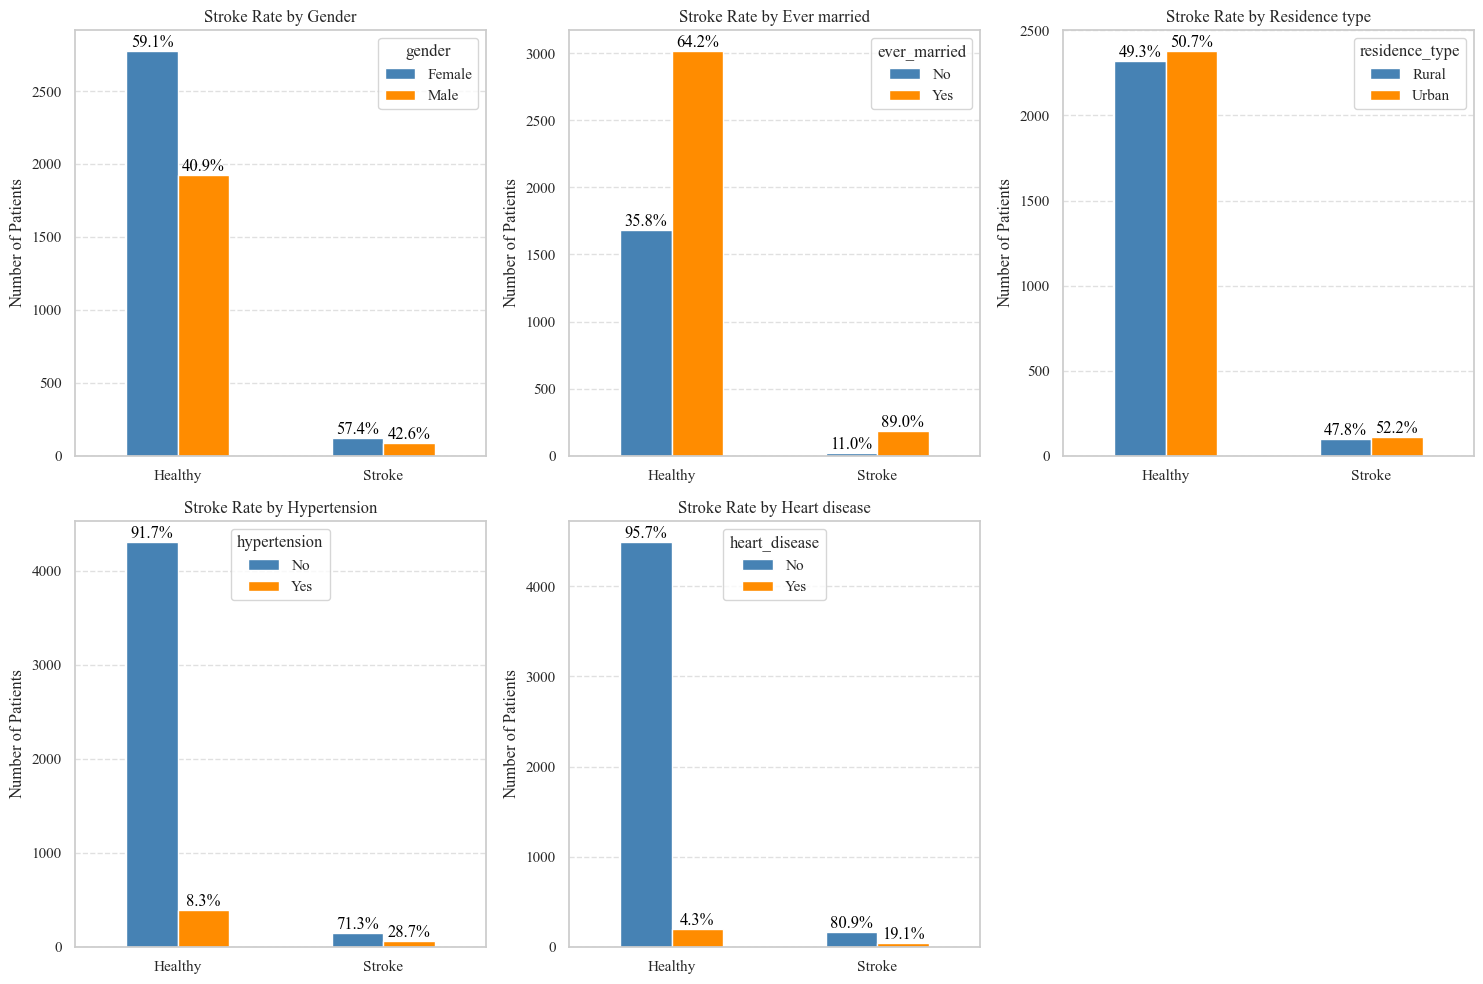

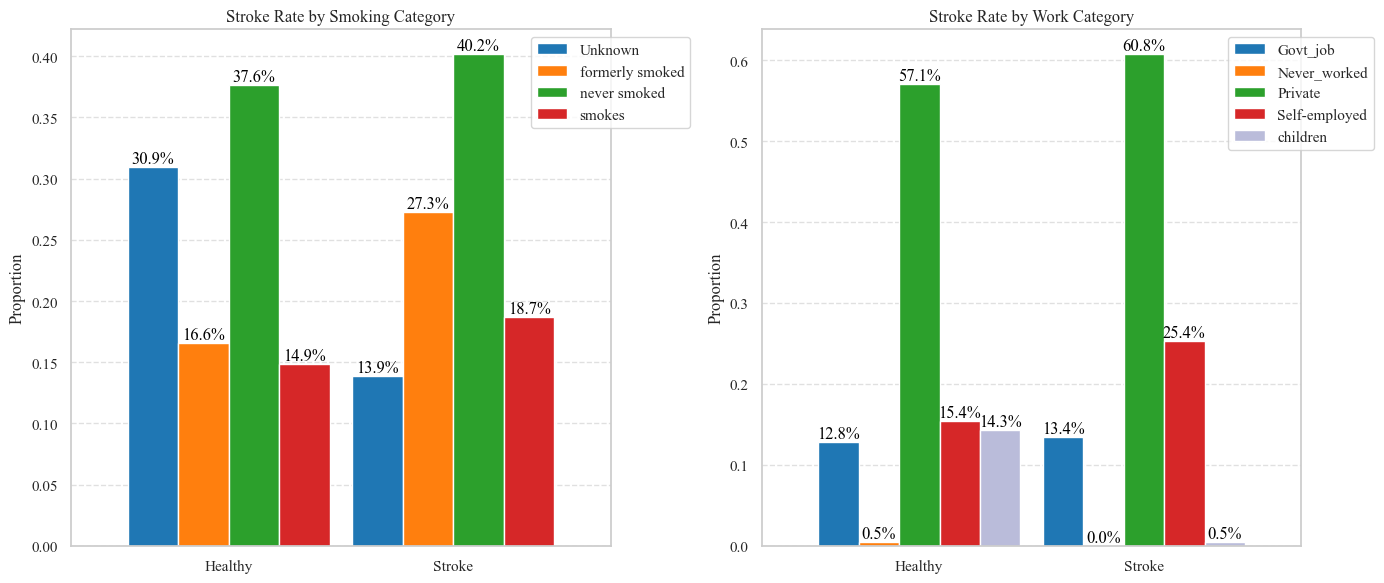

In [75]:
features = [
    "gender",
    "ever_married",
    "residence_type",
    "hypertension",
    "heart_disease",
]
proportions = []

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for i, var in enumerate(features):
    data.groupby("stroke")[var].value_counts().unstack().plot(
        kind="bar",
        ax=axes[i // 3, i % 3],
        color=["steelblue", "darkorange"],
    )
    axes[i // 3, i % 3].set_title(
        f"Stroke Rate by {var.capitalize().replace('_', ' ')}"
    )
    axes[i // 3, i % 3].set_xlabel("")
    axes[i // 3, i % 3].set_ylabel("Number of Patients")
    axes[i // 3, i % 3].set_xticklabels(
        ["Healthy", "Stroke"], rotation=0
    )
    axes[i // 3, i % 3].grid(False)
    axes[i // 3, i % 3].legend(loc="upper right", title=var)
    if var in ["hypertension", "heart_disease"]:
        axes[i // 3, i % 3].legend(
            loc="upper center",
            title=var,
            labels=["No", "Yes"],
        )
    axes[i // 3, i % 3].grid(axis="y", linestyle="--", alpha=0.6)
    proportions.append(
        data.groupby("stroke")[var].value_counts().unstack()
    )
    for tick in axes[i // 3, i % 3].get_xticklabels():
        tick.set_rotation(0)


for ax in axes.flatten():
    if ax.has_data():
        for i, p in enumerate(ax.patches):
            height = p.get_height()
            total = (
                proportions[i].sum(axis=1)[0]
                if i % 2 == 0
                else proportions[i].sum(axis=1)[1]
            )
            percentage = (height / total) * 100
            ax.annotate(
                f"{percentage:.1f}%",
                (p.get_x() + p.get_width() / 2, p.get_height()),
                ha="center",
                va="bottom",
                color="black",
                size=12,
            )

fig.delaxes(axes[1, 2])
plt.tight_layout()
plt.savefig(
    "stroke_rate_by_binary.png",
    dpi=300,
    bbox_inches="tight",
)


features = ["smoking_status", "work_type"]
proportions = []

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
for i, var in enumerate(features):
    data.groupby("stroke")[var].value_counts(
        normalize=True
    ).unstack().plot(
        kind="bar",
        ax=axes[i],
        color=[
            "#1f77b4",
            "#ff7f0e",
            "#2ca02c",
            "#d62728",
            "#BABCDA",
        ],
        width=0.9,
    )
    axes[i].set_title(
        f"Stroke Rate by {var.capitalize().split('_')[0]} Category"
    )
    axes[i].set_xlabel("")
    axes[i].set_ylabel("Proportion")
    axes[i].set_xticklabels(["Healthy", "Stroke"], rotation=0)
    axes[i].grid(False)
    axes[i].legend(loc="upper center", bbox_to_anchor=(1, 1), ncol=1)
    axes[i].grid(axis="y", linestyle="--", alpha=0.6)
    proportions.append(
        data.groupby("stroke")[var].value_counts().unstack()
    )
    for tick in axes[i].get_xticklabels():
        tick.set_rotation(0)

for ax in axes.flatten():
    if ax.has_data():
        for i, p in enumerate(ax.patches):
            height = p.get_height()
            ax.annotate(
                f"{height*100:.1f}%",
                (p.get_x() + p.get_width() / 2, p.get_height()),
                ha="center",
                va="bottom",
                color="black",
                size=12,
            )

plt.tight_layout()

plt.savefig(
    "stroke_rate_by_category.png",
    dpi=300,
    bbox_inches="tight",
)
plt.show()

### Correlation Matrix

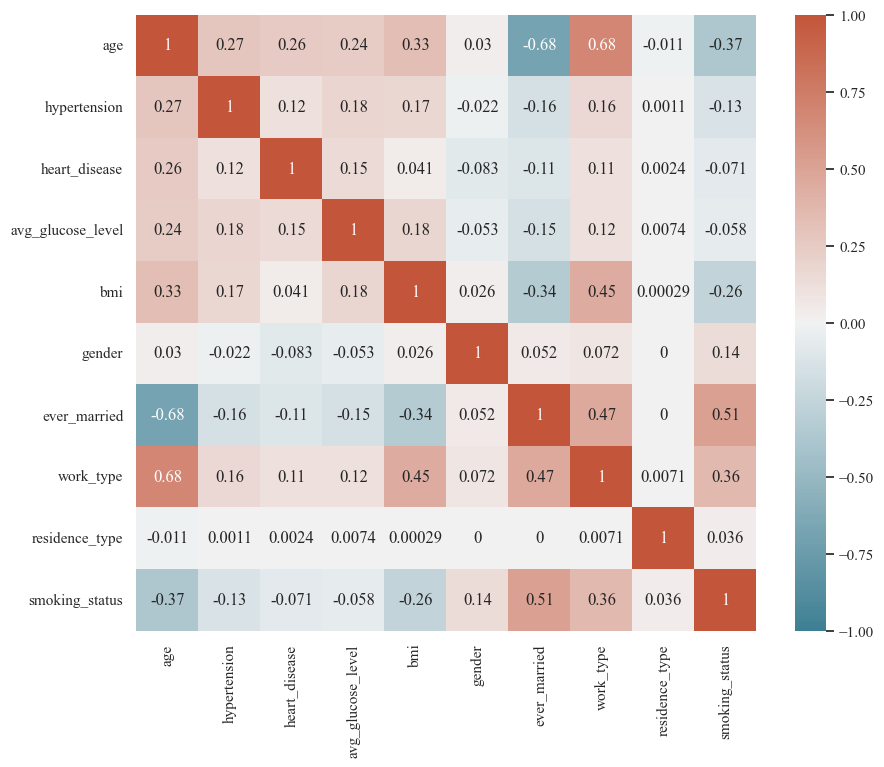

In [76]:
def correlation_ratio(categories, values):
    """
    Compute the correlation ratio (eta) between a categorical and numerical variable.
    """
    categories = pd.factorize(categories)[0]
    fcat, _ = pd.factorize(categories)
    cat_num = np.max(fcat) + 1
    y_avg_array = np.zeros(cat_num)
    n_array = np.zeros(cat_num)
    for i in range(cat_num):
        cat_measures = values[np.argwhere(fcat == i).flatten()]
        n_array[i] = len(cat_measures)
        y_avg_array[i] = np.mean(cat_measures)
    y_total_avg = np.sum(np.multiply(y_avg_array, n_array)) / np.sum(
        n_array
    )
    numerator = np.sum(
        np.multiply(
            n_array,
            np.power(np.subtract(y_avg_array, y_total_avg), 2),
        )
    )
    denominator = np.sum(
        np.power(np.subtract(values, y_total_avg), 2)
    )
    return np.sqrt(numerator / denominator)


def mixed_correlation_matrix(
    data,
    numerical_columns,
    categorical_columns,
    ordinal_columns=None,
    nominal_columns=None,
):
    """
    Compute a correlation matrix for a dataset with mixed variable types.

    Parameters:
        data (pd.DataFrame): The input dataset.
        numerical_columns (list): List of numerical column names.
        categorical_columns (list): List of categorical column names.
        ordinal_columns (list): List of ordinal categorical column names.
        nominal_columns (list): List of nominal categorical column names.

    Returns:
        pd.DataFrame: Correlation matrix.
    """
    
    all_columns = numerical_columns + categorical_columns
    corr_matrix = pd.DataFrame(
        index=all_columns,
        columns=all_columns,
        dtype=float,
    )

    # Numerical-Numerical: Pearson Correlation
    for num1 in numerical_columns:
        for num2 in numerical_columns:
            corr_matrix.loc[num1, num2] = data[num1].corr(data[num2])

    # Numerical-Categorical: Handle binary, ordinal, and nominal separately
    for num in numerical_columns:
        for cat in categorical_columns:
            if data[cat].nunique() <= 1:
                corr_matrix.loc[num, cat] = np.nan
                continue

            # Binary Categorical: Point Biserial Correlation
            if cat in ordinal_columns and data[cat].nunique() == 2:
                try:
                    corr_value = pointbiserialr(
                        data[num], pd.factorize(data[cat])[0]
                    )[0]
                except Exception as e:
                    print(f"Error with {num} and {cat}: {e}")
                    corr_value = np.nan

            # Ordinal Categorical: Spearman's Rank Correlation
            elif cat in ordinal_columns:
                try:
                    corr_value = spearmanr(
                        data[num], pd.factorize(data[cat])[0]
                    )[0]
                except Exception as e:
                    print(f"Error with {num} and {cat}: {e}")
                    corr_value = np.nan

            # Nominal Categorical: Correlation Ratio
            elif cat in nominal_columns:
                try:
                    corr_value = correlation_ratio(
                        data[cat], data[num]
                    )
                except Exception as e:
                    print(f"Error with {num} and {cat}: {e}")
                    corr_value = np.nan

            else:
                corr_value = np.nan

            corr_matrix.loc[num, cat] = corr_value
            corr_matrix.loc[cat, num] = corr_value  # Ensure symmetry

    # Categorical-Categorical: Phi-K 
    try:
        phik_corr = data[categorical_columns].phik_matrix(
            interval_cols=numerical_columns
        )
        for cat1 in categorical_columns:
            for cat2 in categorical_columns:
                if (
                    cat1 in phik_corr.index
                    and cat2 in phik_corr.columns
                ):
                    corr_matrix.loc[cat1, cat2] = phik_corr.loc[
                        cat1, cat2
                    ]
    except Exception as e:
        print(f"Error computing Phi-K: {e}")

    return corr_matrix.astype(float)


categorical_columns = data.select_dtypes(
    include=["object"]
).columns.tolist()
numerical_columns = data.select_dtypes(
    include=["int64", "float64"]
).columns.tolist()
numerical_columns = [
    col for col in numerical_columns if col != "stroke"
]
ordinal_columns = [
    "smoking_status",
    "gender",
    "ever_married",
    "residence_type",
]
nominal_columns = ["work_type"]

corr_matrix = mixed_correlation_matrix(
    data,
    numerical_columns,
    categorical_columns,
    ordinal_columns,
    nominal_columns,
)
corr_matrix = corr_matrix.astype(float)

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap=sns.diverging_palette(220, 20, as_cmap=True),
    vmin=-1,
    vmax=1,
)
plt.show()

**Correlation Analysis Summary:**

The correlation matrix revealed generally weak linear relationships between the variables. The strongest correlations observed, with absolute values ranging from 0.26 to 0.68, are detailed below. While these correlations are relatively modest, their direction and nature are largely consistent with expectations:

1.  **Age & Hypertension** (0.27): A slight positive correlation, suggesting a tendency for hypertension to increase with age.
2.  **Age & Heart Disease** (0.26): A slight positive correlation, indicating a weak association between increasing age and the presence of heart disease.
3.  **BMI & Age** (0.33): A weak positive correlation, implying a slight tendency for BMI to increase with age.
4.  **BMI & Work Type** (0.45): A moderate positive correlation, suggesting some association between body mass index and occupational categories. This might be related to the lifestyle or physical activity differences across work types.
5.  **Ever Married & Age** (-0.68): A moderate negative correlation, indicating that being "ever married" is more common in older individuals within the dataset. This could reflect the age distribution of the sample.
6.  **Ever Married & BMI** (-0.34): A weak negative correlation, suggesting a slight tendency for "ever married" individuals to have lower BMIs.
7.  **Smoking Status & Age** (-0.37): A weak negative correlation, implying a slight tendency for older individuals to belong to a certain smoking status category.
8.  **Smoking Status & BMI** (-0.26): A weak negative correlation, indicating a slight association between smoking status and lower BMI.
9.  **Smoking Status & Ever Married** (0.51): A moderate positive correlation, suggesting a relationship between marital status and smoking habits.
10. **Smoking Status & Work Type** (0.36): A weak positive correlation, indicating a slight association between smoking status and occupational categories.

It's important to note that these correlations are generally weak to moderate, suggesting that while some linear relationships exist, they may not be strong predictors on their own. 

#### Predict missing values


##### BMI - Statistical Tests

The final part of the Exploratory Data Analysis (EDA) will focus on identifying potential features that may help predict missing values and determining the most appropriate imputation approach.

To explore potential predictive relationships, we will examine whether individuals with missing BMI values significantly differ from those with known BMI values in terms of variables like age, work type, etc.
This will help us determine whether the missingness of BMI is related to specific groups (e.g., older individuals, smokers), or if it is randomly distributed across the dataset.


In [77]:
missing_bmi = df[df["bmi"].isnull()]
non_missing_bmi = df[df["bmi"].notnull()]

numerical_columns = ["age", "avg_glucose_level"]
for i in numerical_columns:
    t_stat, p_value = ttest_ind(
        missing_bmi[i], non_missing_bmi[i], nan_policy="omit"
    )
    print(f"{i} difference: p-value = {p_value:.4f}")


categorical_cols = [
    "hypertension",
    "heart_disease",
    "ever_married",
    "work_type",
    "residence_type",
    "smoking_status",
]
for i in categorical_cols:
    contingency_table = pd.crosstab(df["bmi"].isnull(), df[i])
    chi2_stat, p_value, _, expected = chi2_contingency(
        contingency_table
    )
    if np.any(expected < 5) and df[i].nunique() > 2:
        simulated_p_values = [
            chi2_contingency(
                pd.crosstab(
                    df["bmi"].isnull(), np.random.permutation(df[i])
                )
            )[1]
            for _ in range(10000)
        ]
        monte_p = np.mean(np.array(simulated_p_values) <= p_value)
        print(f"{i} difference: Monte Carlo p-value = {monte_p:.4f}")
    else:
        print(f"{i} difference: p-value = {p_value:.4f}")

age difference: p-value = 0.0000
avg_glucose_level difference: p-value = 0.0000
hypertension difference: p-value = 0.0000
heart_disease difference: p-value = 0.0000
ever_married difference: p-value = 0.0120
work_type difference: Monte Carlo p-value = 0.0394
residence_type difference: p-value = 0.6279
smoking_status difference: p-value = 0.0000


Since many of the p-values are < 0.05, we conclude that BMI is **not missing completely at random (MCAR)**. Instead, the missingness of BMI appears to be dependent on other features, such as age, glucose levels, hypertension, heart disease, and smoking status.
To assess whether the differences are practically meaningful, we will calculate effect sizes using **Cohen’s d** for numerical variables (e.g., age, glucose levels) and **Cramer’s V** for categorical variables (e.g., hypertension, smoking status). These measures will help us determine the magnitude of the differences between individuals with missing and non-missing BMI values.

In [78]:
def cohens_d(group1, group2):
    mean_diff = np.mean(group1) - np.mean(group2)
    pooled_std = np.sqrt(
        (np.std(group1, ddof=1) ** 2 + np.std(group2, ddof=1) ** 2)
        / 2
    )
    return mean_diff / pooled_std


for col in [
    "age",
    "avg_glucose_level",
]:  
    d = cohens_d(missing_bmi[col], non_missing_bmi[col])
    print(f"Cohen’s d for {col}: {d:.3f}")

Cohen’s d for age: 0.410
Cohen’s d for avg_glucose_level: 0.409


In [79]:
def cramers_v(contingency_table):
    chi2 = stats.chi2_contingency(contingency_table)[0]
    n = contingency_table.sum().sum()
    k = min(contingency_table.shape) - 1
    return np.sqrt(chi2 / (n * k))


for col in categorical_cols:
    contingency_table = pd.crosstab(df[col], df["bmi"].isnull())
    v = cramers_v(contingency_table)
    print(f"Cramer’s V for {col}: {v:.3f}")

Cramer’s V for hypertension: 0.091
Cramer’s V for heart_disease: 0.096
Cramer’s V for ever_married: 0.035
Cramer’s V for work_type: 0.045
Cramer’s V for residence_type: 0.007
Cramer’s V for smoking_status: 0.085


Based on the results, the differences in age and glucose levels between individuals with missing and non-missing BMI values are noticeable, but not large in magnitude. The categorical variables (hypertension, heart disease, smoking, work type) show weak associations with BMI missingness, suggesting that the missingness of BMI is **not strongly related to these features**.
Given these findings, we can proceed to determine the most appropriate imputation method for the missing BMI values. We will compare two imputation methods: **K-Nearest Neighbors (KNN)**, which imputes missing BMI values based on the values of the most similar individuals, and **Multiple Imputation by Chained Equations (MICE)**, a robust method that generates multiple imputed datasets by modeling each feature iteratively as a function of others.

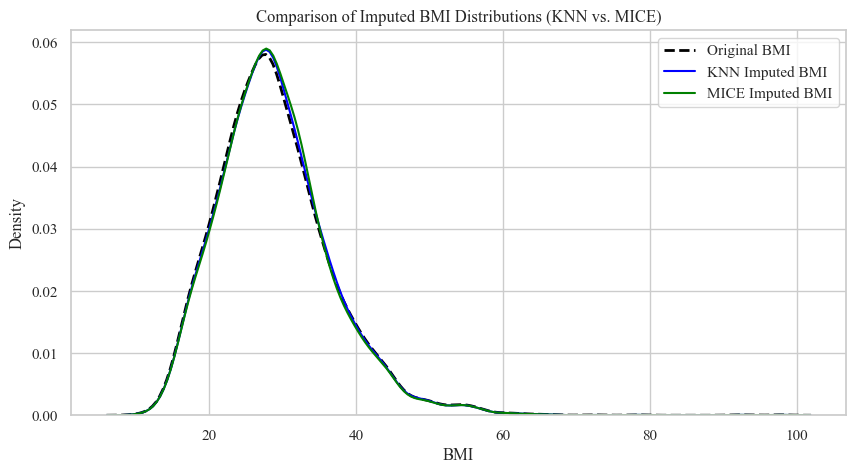


--- Summary Statistics for BMI ---
         Original BMI    KNN BMI   MICE BMI
Mean         28.89456  28.967270  28.949279
Median       28.10000  28.200000  28.200000
Std Dev       7.85432   7.779251   7.724212

--- KS Test Results ---
KNN vs. Original: KS Statistic = 0.0099, p-value = 0.9625
MICE vs. Original: KS Statistic = 0.0117, p-value = 0.8789


In [80]:
features_for_imputation = [
    "age",
    "avg_glucose_level",
    "hypertension",
    "heart_disease",
]
features_for_scaling = [
    "age",
    "avg_glucose_level"
]

data_knn = df.copy()
data_mice = df.copy()
original_bmi = df.loc[df["bmi"].notna(), "bmi"]

# --- KNN Imputation ---
knn_imputer = KNNImputer(n_neighbors=5)
scaler = StandardScaler()
data_knn[features_for_scaling] = scaler.fit_transform(
    data_knn[features_for_scaling]
)
data_knn["bmi"] = knn_imputer.fit_transform(
    data_knn[["bmi"] + features_for_imputation]
)[:, 0]

# --- MICE (Iterative Imputer) ---
mice_imputer = IterativeImputer(
    estimator=BayesianRidge(), max_iter=10, random_state=42
)
data_mice["bmi"] = mice_imputer.fit_transform(
    data_mice[["bmi"] + features_for_imputation]
)[:, 0]

plt.figure(figsize=(10, 5))
sns.kdeplot(
    original_bmi,
    label="Original BMI",
    color="black",
    linestyle="--",
    linewidth=2,
)
sns.kdeplot(data_knn["bmi"], label="KNN Imputed BMI", color="blue")
sns.kdeplot(
    data_mice["bmi"], label="MICE Imputed BMI", color="green"
)
plt.xlabel("BMI")
plt.ylabel("Density")
plt.title("Comparison of Imputed BMI Distributions (KNN vs. MICE)")
plt.legend()
plt.show()

summary = pd.DataFrame(
    {
        "Original BMI": [
            original_bmi.mean(),
            original_bmi.median(),
            original_bmi.std(),
        ],
        "KNN BMI": [
            data_knn["bmi"].mean(),
            data_knn["bmi"].median(),
            data_knn["bmi"].std(),
        ],
        "MICE BMI": [
            data_mice["bmi"].mean(),
            data_mice["bmi"].median(),
            data_mice["bmi"].std(),
        ],
    },
    index=["Mean", "Median", "Std Dev"],
)

print("\n--- Summary Statistics for BMI ---")
print(summary)

# --- Kolmogorov-Smirnov Test (to check distribution differences) ---
ks_knn = ks_2samp(original_bmi, data_knn["bmi"])
ks_mice = ks_2samp(original_bmi, data_mice["bmi"])

print("\n--- KS Test Results ---")
print(
    f"KNN vs. Original: KS Statistic = {ks_knn.statistic:.4f}, p-value = {ks_knn.pvalue:.4f}"
)
print(
    f"MICE vs. Original: KS Statistic = {ks_mice.statistic:.4f}, p-value = {ks_mice.pvalue:.4f}"
)

Both methods perform **very similarly**, but **KNN has a slightly better KS p-value**, meaning it **preserves the original distribution slightly better**.
Since **KNN is computationally simpler**, it would be the **preferred choice**.

##### Smoking Status - Statistical Tests

Following the methodology employed for BMI, we will investigate if there are significant differences in age, work type, and other variables between individuals with unknown and known smoking status.

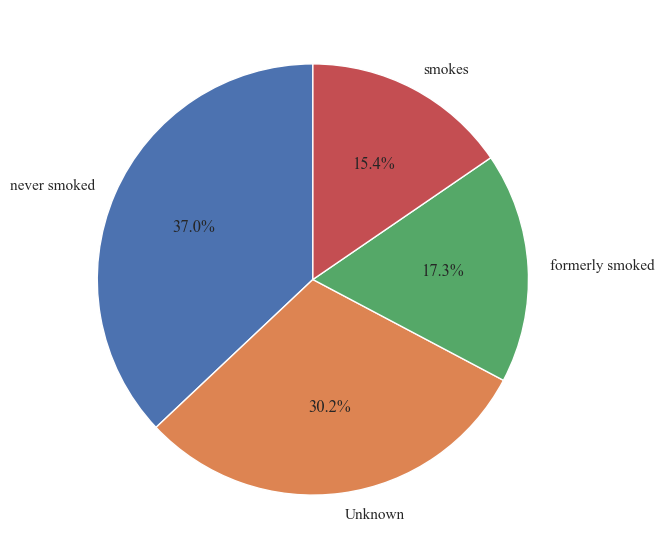

The total number of patients with unknown smoking status: 1544
Which represents 30.22% of the dataset


In [82]:
df.smoking_status.value_counts().plot.pie(
    autopct="%1.1f%%",
    startangle=90,
    figsize=(7, 7),
)
plt.ylabel("")
plt.show()

print(f"The total number of patients with unknown smoking status: {df[df['smoking_status'] == 'Unknown'].shape[0]}")
print(f"Which represents {df[df['smoking_status'] == 'Unknown'].shape[0] / df.shape[0] * 100:.2f}% of the dataset")

In [83]:
# --- T-test and Cohen's d for Unknown vs. Other Smoking Status ---
def cohens_d(group1, group2):
    """Calculates Cohen's d for two independent groups."""
    diff = np.mean(group1) - np.mean(group2)
    n1, n2 = len(group1), len(group2)
    var1, var2 = np.var(group1, ddof=1), np.var(group2, ddof=1)
    pooled_std = np.sqrt(((n1 - 1) * var1 + (n2 - 1) * var2) / (n1 + n2 - 2))
    d = diff / pooled_std
    return d

numerical_columns = ["age", "avg_glucose_level", "bmi"]
smoking_levels = ["never smoked", "formerly smoked", "smokes"]

for num_col in numerical_columns:
    print(f"\nCohen's d for {num_col}:")
    for smoke_level in smoking_levels:
        unknown_group = df[df["smoking_status"] == "Unknown"][num_col]
        other_group = df[df["smoking_status"] == smoke_level][num_col]

        t_stat, p_value = stats.ttest_ind(unknown_group, other_group, equal_var=False)  #Welch's t-test
        print(f"  Unknown vs. {smoke_level}: t-stat = {t_stat:.4f}, p-value = {p_value:.4f}")
        
        effect_size = cohens_d(unknown_group, other_group)
        print(f"    Cohen's d: {effect_size:.4f}")


Cohen's d for age:
  Unknown vs. never smoked: t-stat = -21.0903, p-value = 0.0000
    Cohen's d: -0.7406
  Unknown vs. formerly smoked: t-stat = -28.4080, p-value = 0.0000
    Cohen's d: -1.0927
  Unknown vs. smokes: t-stat = -19.5014, p-value = 0.0000
    Cohen's d: -0.7493

Cohen's d for avg_glucose_level:
  Unknown vs. never smoked: t-stat = -5.5988, p-value = 0.0000
    Cohen's d: -0.1874
  Unknown vs. formerly smoked: t-stat = -6.6590, p-value = 0.0000
    Cohen's d: -0.3083
  Unknown vs. smokes: t-stat = -4.3745, p-value = 0.0000
    Cohen's d: -0.2076

Cohen's d for bmi:
  Unknown vs. never smoked: t-stat = -15.8914, p-value = 0.0000
    Cohen's d: -0.5498
  Unknown vs. formerly smoked: t-stat = -16.1221, p-value = 0.0000
    Cohen's d: -0.6505
  Unknown vs. smokes: t-stat = -15.0184, p-value = 0.0000
    Cohen's d: -0.6299


The analysis of Cohen's d revealed statistically significant differences (p < 0.0001) in age, average glucose level, and BMI between individuals with unknown smoking status and each of the known smoking status categories (never smoked, formerly smoked, and smokes). However, the magnitude of these differences varied significantly across the variables.

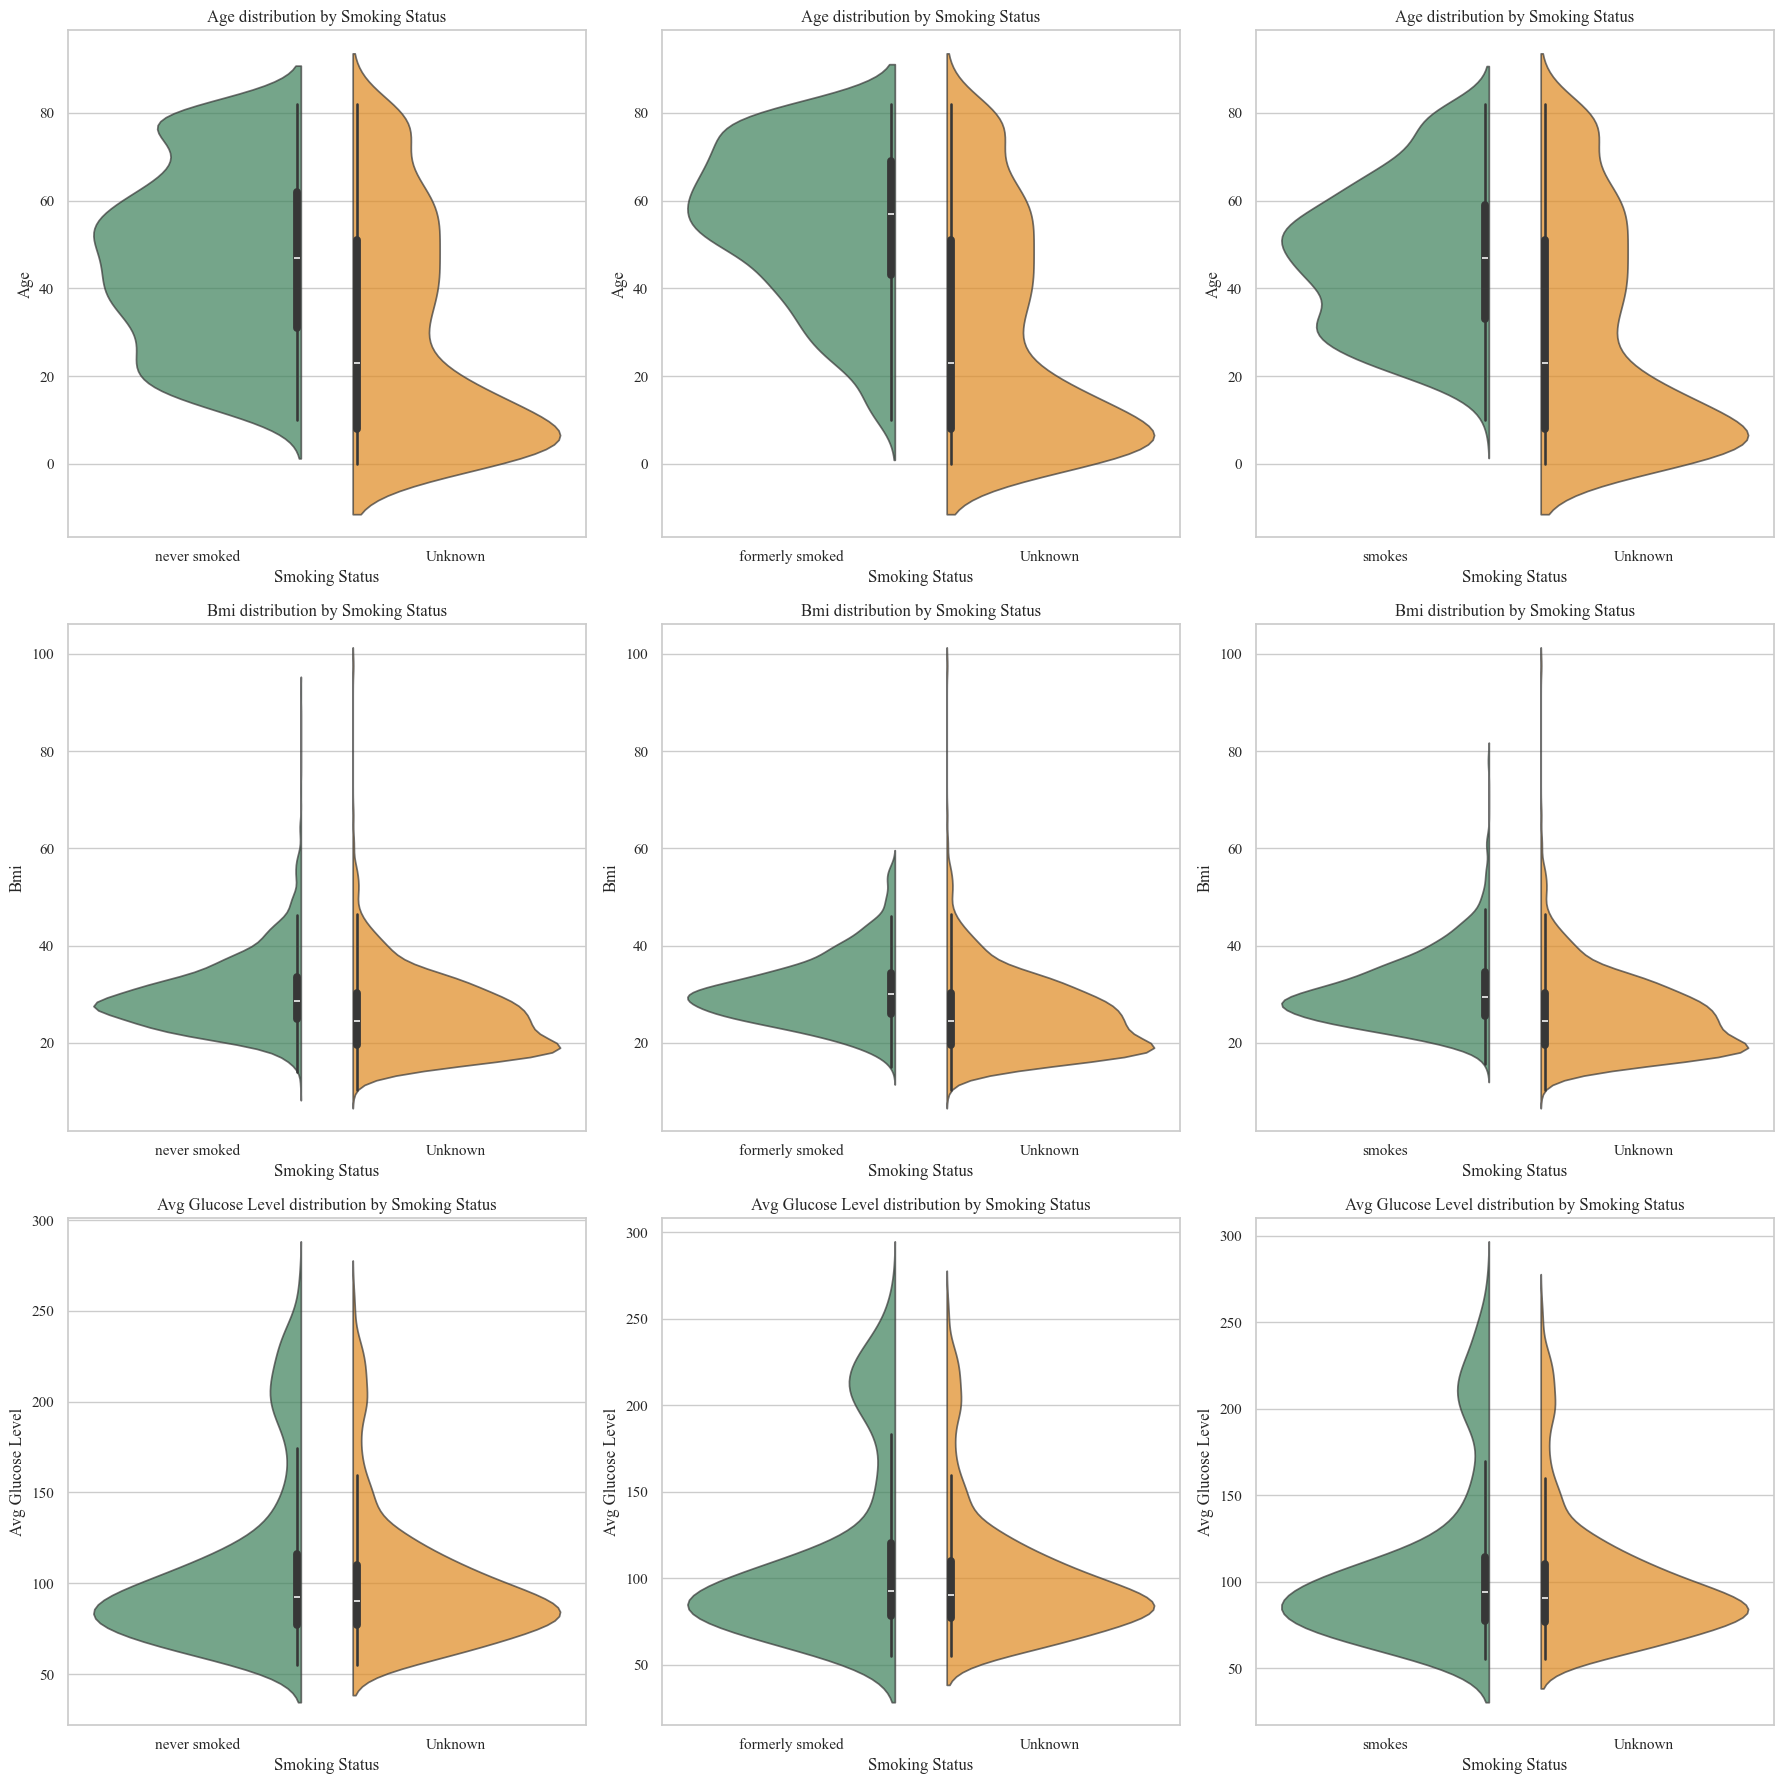

In [84]:
def violineplot(data, x, y, hue, ax):
    sns.violinplot(
        x=x,
        y=y,
        hue=hue,
        data=data,
        split=True,
        palette=["seagreen", "darkorange"],
        ax=ax,
        alpha=0.7,
        scale="width",
    )
    ax.set_title(f"{y.title().replace('_',' ')} distribution by {x.replace('_', ' ').title()}")
    ax.set_xlabel("Smoking Status")
    ax.set_ylabel(y.title().replace('_', ' '))

fig, axes = plt.subplots(3, 3, figsize=(18, 18))

for i, level in enumerate(["never smoked", "formerly smoked", "smokes"]):
    subset = df[(df["smoking_status"] == "Unknown") | (df["smoking_status"] == level)]
    for j, var in enumerate(["age", "bmi", "avg_glucose_level"]):
        violineplot(subset, "smoking_status", var, "smoking_status", axes[j, i])

plt.tight_layout()
plt.show()

- As represented in the graph for age, the Cohen's d values were substantial, ranging from -0.7406 to -1.0927. This indicates a large effect size, suggesting that the 'Unknown' smoking status group is significantly younger on average compared to all other smoking status groups. The strongest effect was observed when comparing 'Unknown' to 'formerly smoked' (d = -1.0927), implying the most pronounced age difference in this comparison.

- The Cohen's d values for average glucose level were considerably smaller, ranging from -0.1874 to -0.3083. These values represent small to medium effect sizes, indicating that while statistically significant, the differences in average glucose level between the 'Unknown' group and the other smoking status groups are relatively modest. This can be appreciated in the graph. The largest effect was observed when comparing the 'Unknown' group with the 'formerly smoked' group.

- For BMI, the Cohen's d values fell within the medium effect size range, ranging from -0.5498 to -0.6505. This suggests that there are moderate differences in BMI between the 'Unknown' group and the known smoking status groups. Once again, the largest effect was observed when comparing the 'Unknown' group with the 'formerly smoked' group.

In [85]:
# --- Chi-Square Test and Cramer's V for Categorical Variables ---
def cramers_v(contingency_table):
    """Calculates Cramer's V for a contingency table."""
    chi2 = chi2_contingency(contingency_table)[0]
    n = contingency_table.sum().sum()
    phi2 = chi2 / n
    r, k = contingency_table.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

categorical_cols = [
    "gender",
    "hypertension",
    "heart_disease",
    "ever_married",
    "work_type",
    "residence_type",
]

relevant_features = [] 

for i in categorical_cols:
    contingency_table = pd.crosstab(df["smoking_status"] == "Unknown", df[i])
    chi2_stat, p_value, _, expected = chi2_contingency(contingency_table)

    if np.any(expected < 5) and df[i].nunique() > 2:
        simulated_p_values = [
            chi2_contingency(
                pd.crosstab(
                    df["smoking_status"] == "Unknown", np.random.permutation(df[i])
                )
            )[1]
            for _ in range(10000)
        ]
        monte_p = np.mean(np.array(simulated_p_values) <= p_value)
        print(
            f"Association between 'Unknown' smoking status and {i}: Monte Carlo p-value = {monte_p:.4f}"
        )
        if monte_p < 0.05:
            relevant_features.append(i)
    else:
        print(f"Association between 'Unknown' smoking status and {i}: p-value = {p_value:.4f}")
        if p_value < 0.05:
            relevant_features.append(i)

for feature in relevant_features:
    contingency_table = pd.crosstab(df["smoking_status"] == "Unknown", df[feature])
    v = cramers_v(contingency_table)
    print(f"Cramer's V between 'Unknown' smoking status and {feature}: {v:.4f}")

Association between 'Unknown' smoking status and gender: p-value = 0.0000
Association between 'Unknown' smoking status and hypertension: p-value = 0.0000
Association between 'Unknown' smoking status and heart_disease: p-value = 0.0000
Association between 'Unknown' smoking status and ever_married: p-value = 0.0000
Association between 'Unknown' smoking status and work_type: p-value = 0.0000
Association between 'Unknown' smoking status and residence_type: p-value = 0.9010
Cramer's V between 'Unknown' smoking status and gender: 0.0574
Cramer's V between 'Unknown' smoking status and hypertension: 0.1401
Cramer's V between 'Unknown' smoking status and heart_disease: 0.0643
Cramer's V between 'Unknown' smoking status and ever_married: 0.3316
Cramer's V between 'Unknown' smoking status and work_type: 0.5133


The chi-square tests revealed highly significant associations (p < 0.0001) between the 'Unknown' smoking status and several categorical variables: gender, hypertension, heart disease, ever married, and work type. In contrast, the association between 'Unknown' smoking status and residence type was not statistically significant (p = 0.9010).

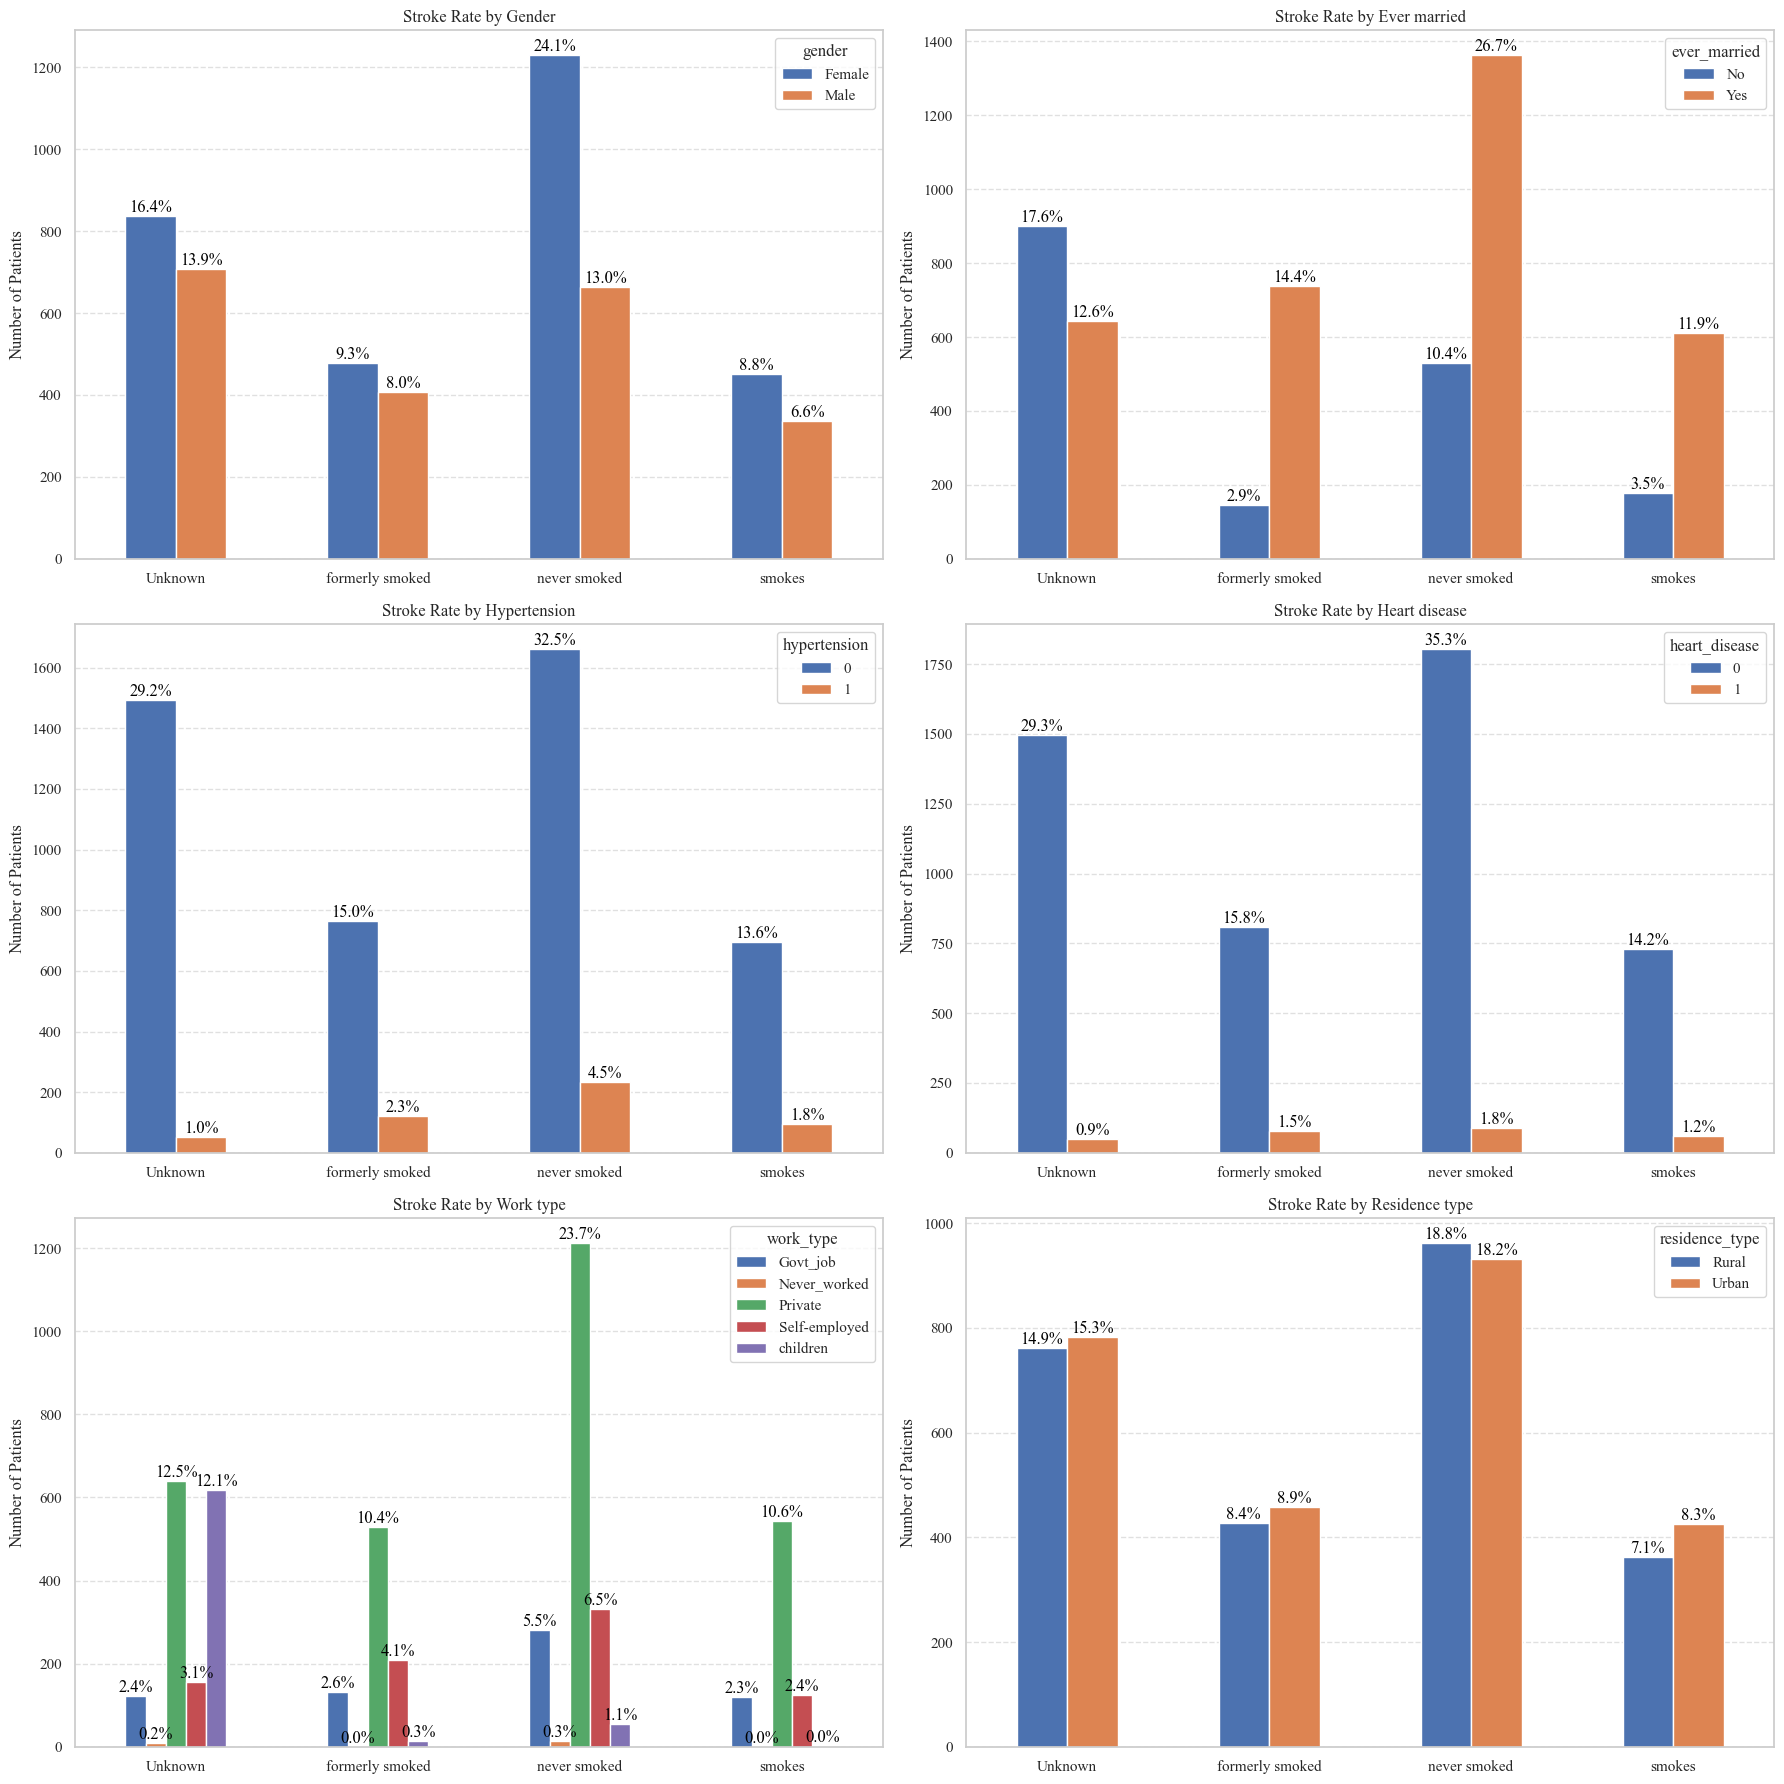

In [86]:
features = [
    "gender",
    "ever_married",
    "hypertension",
    "heart_disease",
    "work_type",
    "residence_type",
]
proportions = []

fig, axes = plt.subplots(3, 2, figsize=(18, 18))

for i, var in enumerate(features):
    data_grouped = df.groupby("smoking_status")[var].value_counts().unstack()
    data_grouped.plot(
        kind="bar",
        ax=axes[i // 2, i % 2],
    )
    axes[i // 2, i % 2].set_title(
        f"Stroke Rate by {var.capitalize().replace('_', ' ')}"
    )
    axes[i // 2, i % 2].set_xlabel("")
    axes[i // 2, i % 2].set_ylabel("Number of Patients")
    axes[i // 2, i % 2].grid(False)
    axes[i // 2, i % 2].legend(loc="upper right", title=var)

    axes[i // 2, i % 2].grid(axis="y", linestyle="--", alpha=0.6)
    proportions.append(data_grouped)
    for tick in axes[i // 2, i % 2].get_xticklabels():
        tick.set_rotation(0)

for ax in axes.flatten():
    if ax.has_data():
        for p in ax.patches:
            height = p.get_height()
            total = proportions[axes.flatten().tolist().index(ax)].sum(axis=1).sum()
            percentage = (height / total) * 100
            ax.annotate(
                f"{percentage:.1f}%",
                (p.get_x() + p.get_width() / 2, p.get_height()),
                ha="center",
                va="bottom",
                color="black",
                size=12,
            )

plt.tight_layout()
plt.savefig(
    "smoking_rate_by_categorical.png",
    dpi=300,
    bbox_inches="tight",
)
plt.show()

- The association between 'Unknown' smoking status and gender is weak, as indicated by the low Cramer's V value. While statistically significant, the practical significance of this association might be limited.

- The association between 'Unknown' smoking status and hypertension is considered small. This suggests that while there is a statistically significant relationship, the effect size is not substantial.

- Similar to gender, the association between 'Unknown' smoking status and heart disease is weak, with a low Cramer's V value. This implies a limited practical association.

- The association between 'Unknown' smoking status and ever married is moderate. This suggests a more substantial relationship compared to gender, hypertension, and heart disease. The marital status is likely to be useful when trying to predict the unknown smoking status.

- The association between 'Unknown' smoking status and work type is strong. This indicates a significant relationship, with work type being a potentially important predictor for the 'Unknown' smoking status. The work type is the most useful feature, from the listed categorical features, when trying to predict the unknown smoking status.

- The lack of statistical significance (p = 0.9010) confirms that residence type is not associated with the 'Unknown' smoking status. Therefore, Cramer's V was not calculated for this variable.

In [87]:
# Preprocessing for Imputation
data = df.copy()

features_for_imputation = [
    "age", "avg_glucose_level", "bmi", "ever_married", "work_type"
]  

data = data[features_for_imputation + ["smoking_status"]]

data["ever_married"] = data["ever_married"].map({"Yes": 1, "No": 0})

encoder_work = OneHotEncoder(sparse_output=False, drop="first")

work_encoded = encoder_work.fit_transform(data[['work_type']])
work_encoded_df = pd.DataFrame(work_encoded, columns=encoder_work.get_feature_names_out(['work_type']))
data_encoded = pd.concat([data, work_encoded_df], axis=1)

data_encoded.drop(columns=["work_type"], inplace=True)

encoder_ss = OrdinalEncoder(categories=[["never smoked", "formerly smoked", "smokes", "Unknown"]])
data_encoded["smoking_status_encoded"] = encoder_ss.fit_transform(data_encoded[["smoking_status"]])

data_encoded.loc[data_encoded["smoking_status"] == "Unknown", "smoking_status_encoded"] = np.nan
data_encoded["smoking_status_encoded"] = data_encoded["smoking_status_encoded"].fillna(-1)  # Replace NaN with -1
data_encoded["smoking_status_encoded"] = data_encoded["smoking_status_encoded"].astype(int)  # Convert to int
data_encoded["smoking_status_encoded"] = data_encoded["smoking_status_encoded"].replace(-1, np.nan)  # Restore NaN

In [91]:
# --- KNN Classifier ---
impute_features = [
    "avg_glucose_level", "bmi", "ever_married"] + list(encoder_work.get_feature_names_out(["work_type"]))

features_for_scaling = [
    "age", "avg_glucose_level", "bmi"
]

scaler = StandardScaler()

data_encoded_knn = data_encoded.copy()

known = data_encoded_knn.loc[~pd.isna(data_encoded_knn["smoking_status_encoded"])]
missing = data_encoded_knn.loc[pd.isna(data_encoded_knn["smoking_status_encoded"])]

known[features_for_scaling] = scaler.fit_transform(
    known[features_for_scaling]
)

missing[features_for_scaling] = scaler.transform(
    missing[features_for_scaling]
)

param_grid = {
    'n_neighbors': [3, 5, 7, 10],
    'weights': ['uniform', 'distance']
}

knn = KNeighborsClassifier(n_neighbors=5, weights='uniform')

grid_search = GridSearchCV(knn, param_grid, cv=5)

grid_search.fit(
    known[impute_features],
    known["smoking_status_encoded"],
)

knn_clf = grid_search.best_estimator_

preds = knn_clf.predict(missing[impute_features])
data_encoded_knn.loc[
    pd.isna(data_encoded_knn["smoking_status_encoded"]), "smoking_status_encoded"
] = preds

data_encoded_knn["smoking_status_imputed"] = encoder_ss.inverse_transform(data_encoded_knn[["smoking_status_encoded"]]).flatten()

data_encoded_knn.loc[
    (data_encoded_knn["age"] <= 10) & (data_encoded_knn["smoking_status"] != "never smoked"),
    "smoking_status_imputed",
] = "never smoked"

In [94]:
# --- MICE Imputation ---
data_encoded_mice = data_encoded.copy() 

param_grid = {
    'max_depth': [3, 5, 7, 10, None],  
    'min_samples_split': [2, 5, 10],   
    'min_samples_leaf': [1, 2, 4]      
}

dt_regressor = DecisionTreeRegressor(random_state=42)
grid_search = GridSearchCV(estimator=dt_regressor, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(data_encoded_mice[["smoking_status_encoded"] + impute_features].dropna(), data_encoded_mice["smoking_status_encoded"].dropna())
best_dt_regressor = grid_search.best_estimator_

mice_imputer = IterativeImputer(max_iter=200, random_state=42, estimator=best_dt_regressor)

data_encoded_mice["smoking_status_encoded"] = mice_imputer.fit_transform(
    data_encoded_mice[["smoking_status_encoded"] + impute_features]
)[:, 0]

data_encoded_mice["smoking_status_encoded"] = np.clip(
    np.round(data_encoded_mice["smoking_status_encoded"]), 0, 2
).astype(int)
data_encoded_mice["smoking_status_imputed"] = encoder_ss.inverse_transform(data_encoded_mice[["smoking_status_encoded"]]).flatten()
data_encoded_mice.loc[
    (data_encoded_mice["age"] <= 10) & (data_encoded_mice["smoking_status"] != "never smoked"),
    "smoking_status_imputed"
] = "never smoked"


--- Smoking Status Imputation Comparison ---
KNN Imputed Smoking Status Distribution:
smoking_status_imputed
formerly smoked    0.191623
never smoked       0.641417
smokes             0.166960
Name: proportion, dtype: float64

MICE Imputed Smoking Status Distribution:
smoking_status_imputed
formerly smoked    0.354277
never smoked       0.491486
smokes             0.154238
Name: proportion, dtype: float64

Original Smoking Status Distribution:
smoking_status
Unknown            0.302212
formerly smoked    0.173028
never smoked       0.370327
smokes             0.154433
Name: proportion, dtype: float64


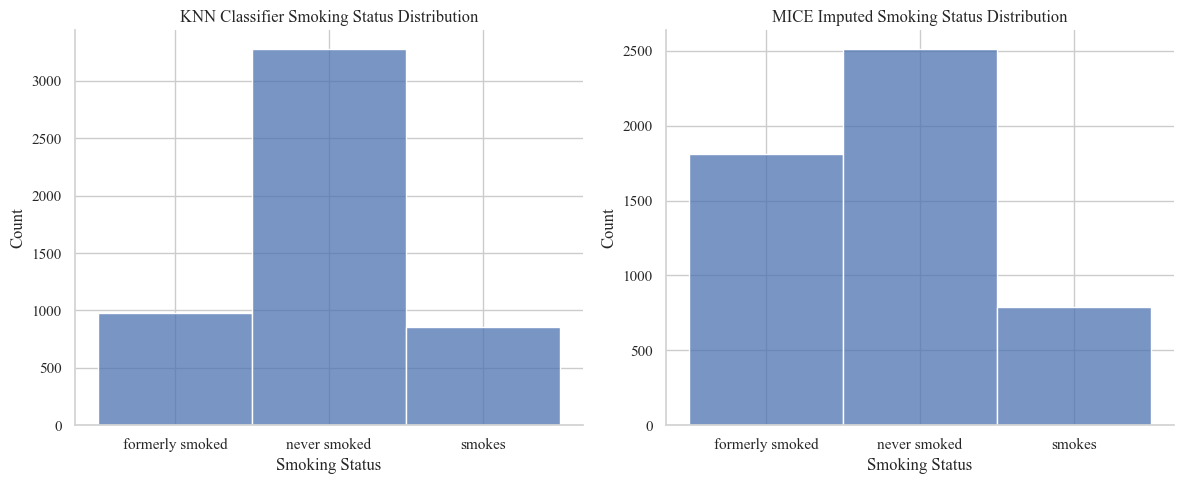


Agreement Between KNN and MICE: 83.73%


In [210]:
# --- Compare KNN vs. MICE ---
print("\n--- Smoking Status Imputation Comparison ---")
print("KNN Imputed Smoking Status Distribution:")
print(data_encoded_knn["smoking_status_imputed"].value_counts(normalize=True).sort_index())

print("\nMICE Imputed Smoking Status Distribution:")
print(data_encoded_mice["smoking_status_imputed"].value_counts(normalize=True).sort_index())

print("\nOriginal Smoking Status Distribution:")
print(data["smoking_status"].value_counts(normalize=True).sort_index())

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(data_encoded_knn["smoking_status_imputed"], ax=axes[0], discrete=True)
axes[0].set_title("KNN Classifier Smoking Status Distribution")
axes[0].set_xlabel("Smoking Status")
axes[0].set_ylabel("Count")

sns.histplot(data_encoded_mice["smoking_status_imputed"], ax=axes[1], discrete=True)
axes[1].set_title("MICE Imputed Smoking Status Distribution")
axes[1].set_xlabel("Smoking Status")
axes[1].set_ylabel("Count")

plt.tight_layout()
plt.show()

# --- Agreement Analysis ---
agreement_rate = (data_encoded_knn["smoking_status_imputed"] == data_encoded_mice["smoking_status_imputed"]).mean()
print(f"\nAgreement Between KNN and MICE: {agreement_rate:.2%}")


- Both KNN and MICE tend to over-represent "never smoked" after imputation.
- MICE increases the formerly smoked category more than KNN.

In [211]:
# --- Test Data Imputation MICE --- 
# randomly introduce NaN values in the test set
test = data_encoded_mice.copy()
nan_indices = np.random.choice(test.index, size=int(len(test) * 0.1), replace=False) 
test.loc[nan_indices, "smoking_status_encoded"] = np.nan
test["smoking_status_encoded"] = mice_imputer.fit_transform( 
    test[["smoking_status_encoded"] + impute_features]
)[:, 0]

test["smoking_status_encoded"] = np.clip(
    np.round(test["smoking_status_encoded"]), 0, 2
).astype(int)

test["smoking_status_imputed"] = encoder_ss.inverse_transform(test[["smoking_status_encoded"]]).flatten()

print("\n--- Test Data Imputation Comparison ---")
print("Test Data Imputed Smoking Status Distribution:")
print(test["smoking_status_imputed"].value_counts(normalize=True).sort_index())
print("\nMICE Imputed Smoking Status Distribution:")
print(data_encoded_mice["smoking_status_imputed"].value_counts(normalize=True).sort_index())



--- Test Data Imputation Comparison ---
Test Data Imputed Smoking Status Distribution:
smoking_status_imputed
formerly smoked    0.410648
never smoked       0.449012
smokes             0.140341
Name: proportion, dtype: float64

MICE Imputed Smoking Status Distribution:
smoking_status_imputed
formerly smoked    0.354277
never smoked       0.491486
smokes             0.154238
Name: proportion, dtype: float64


The MICE imputed test data distribution is very close to the MICE imputed full dataset distribution.\
This indicates that MICE is able to accurately impute the missing data, and that it is consistent.

In [212]:
# --- Test Data Imputation KNN ---
# randomly introduce NaN values in the test set
test = data_encoded_knn.copy()

nan_indices = np.random.choice(test.index, size=int(len(test) * 0.1), replace=False)  # 10% NaNs
test.loc[nan_indices, "smoking_status_encoded"] = np.nan

test["smoking_status_encoded"] = knn_clf.predict( 
    test[impute_features]
)
test["smoking_status_imputed"] = encoder_ss.inverse_transform(test[["smoking_status_encoded"]]).flatten()

print("\n--- Test Data Imputation Comparison ---")
print("Test Data Imputed Smoking Status Distribution:")
print(test["smoking_status_imputed"].value_counts(normalize=True).sort_index())
print("\nKNN Classification Smoking Status Distribution:")
print(data_encoded_knn["smoking_status_imputed"].value_counts(normalize=True).sort_index())


--- Test Data Imputation Comparison ---
Test Data Imputed Smoking Status Distribution:
smoking_status_imputed
formerly smoked    0.057350
never smoked       0.877080
smokes             0.065571
Name: proportion, dtype: float64

KNN Classification Smoking Status Distribution:
smoking_status_imputed
formerly smoked    0.191623
never smoked       0.641417
smokes             0.166960
Name: proportion, dtype: float64


The KNN classifier imputed test data distribution differs from the KNN classifier full dataset distribution.\
The formerly smoked category, is much higher in the full dataset imputation, than in the test data imputation.\
This indicates that KNN is less consistent than MICE.

##### Conclusion

Based on the observed consistency and distributional similarity, MICE imputation was chosen as the preferred method for imputing the missing smoking_status values. MICE's regression-based approach and iterative refinement likely contribute to its superior performance compared to KNN Classifier. MICE's ability to maintain a distribution closer to the original data, and its consistency when imputing fake nan values, makes it the preferred method.